# $ \text{Video Killed The Radio Star}$ $\color{red}{...Diffusion}$

Notebook by David Marx ([@DigThatData](https://twitter.com/digthatdata))

Shared under MIT license


# $\text{FAQ}$

**What is this?**

Point this notebook at a youtube url and it'll make a music video for you.

**How does this animation technique work?**

For each text prompt you provide, the notebook will...

1. Generate an image based on that text prompt (using stable diffusion)
2. Use the generated image as the `init_image` to recombine with the text prompt to generate variations similar to the first image. This produces a sequence of extremely similar images based on the original text prompt
3. Images are then intelligently reordered to find the smoothest animation sequence of those frames
3. This image sequence is then repeated to pad out the animation duration as needed

The technique demonstrated in this notebook was inspired by a [video](https://www.youtube.com/watch?v=WJaxFbdjm8c) created by Ben Gillin.

**How are lyrics transcribed?**

This notebook uses openai's recently released 'whisper' model for performing automatic speech recognition. 
OpenAI was kind enough to offer several different sizes of this model which each have their own pros and cons. 
This notebook uses the largest whisper model for transcribing the actual lyrics. Additionally, we use the 
smallest model for performing the lyric segmentation. Neither of these models is perfect, but the results 
so far seem pretty decent.

The first draft of this notebook relied on subtitles from youtube videos to determine timing, which was
then aligned with user-provided lyrics. Youtube's automated captions are powerful and I'll update the
notebook shortly to leverage those again, but for the time being we're just using whisper for everything
and not referencing user-provided captions at all.

**Something didn't work quite right in the transcription process. How do fix the timing or the actual lyrics?**

The notebook is divided into several steps. Between each step, a "storyboard" file is updated. If you want to
make modifications, you can edit this file directly and those edits should be reflected when you next load the
file. Depending on what you changed and what step you run next, your changes may be ignored or even overwritten.
Still playing with different solutions here.

**Can I provide my own images to 'bring to life' and associate with certain lyrics/sequences?**

Yes, you can! As described above: you just need to modify the storyboard. Will describe this functionality in
greater detail after the implementation stabilizes a bit more.

**This gave me an idea and I'd like to use just a part of your process here. What's the best way to reuse just some of the machinery you've developed here?**

Most of the functionality in this notebook has been offloaded to library I published to pypi called `vktrs`. I strongly encourage you to import anything you need 
from there rather than cutting and pasting function into a notebook. Similarly, if you have ideas for improvements, please don't hesitate to submit a PR!

**How can I support your work or work like it?**

This notebook was made possible thanks to ongoing support from [stability.ai](https://stability.ai/). The best way to support my work is to share it with your friends, [report bugs](https://github.com/dmarx/video-killed-the-radio-star/issues/new), [suggest features](https://github.com/dmarx/video-killed-the-radio-star/discussions) or to donate to open source non-profits :) 

## $0.$ Setup

In [1]:
# @title # 📊 Check GPU Status

import pandas as pd
import subprocess

def gpu_info():
    outv = subprocess.run([
        'nvidia-smi',
            # these lines concatenate into a single query string
            '--query-gpu='
            'timestamp,'
            'name,'
            'utilization.gpu,'
            'utilization.memory,'
            'memory.used,'
            'memory.free,'
            ,
        '--format=csv'
        ],
        stdout=subprocess.PIPE).stdout.decode('utf-8')

    header, rec = outv.split('\n')[:-1]
    return pd.DataFrame({' '.join(k.strip().split('.')).capitalize():v for k,v in zip(header.split(','), rec.split(','))}, index=[0]).T

gpu_info()

,0
Timestamp,2023/06/01 09:34:23.222
Name,NVIDIA GeForce RTX 3090
Utilization gpu [%],0 %
Utilization memory [%],0 %
Memory used [mib],6 MiB
Memory free [mib],24253 MiB


In [2]:
%%capture
# @title # 🛠️ Install dependencies

try: 
    import google.colab
    local=False
except:
    local=True

# TODO: pin versions
    
# local only additional dependencies
if local:
    %pip install pandas torch pillow beautifulsoup4 scipy toolz numpy lxml librosa scikit-learn

# dependencies for both colab and local
%pip install yt-dlp python-tsp stability-sdk diffusers transformers ftfy accelerate omegaconf
%pip install openai-whisper panel huggingface_hub ipywidgets safetensors
%pip install stability-sdk[anim_ui] keyframed
%pip install demucs
%pip install parse

In [3]:
# @title # 🔑 Provide your API Key

# TODO: rework instructions/description here
# TODO: add support for whisper API

# @markdown Running this cell will prompt you to enter your API Key below. 

# @markdown To get your API key, visit https://beta.dreamstudio.ai/membership

# @markdown ---

# @markdown A note on security best practices: **don't publish your API key.**

# @markdown We're using a form field designed for sensitive data like passwords.
# @markdown This notebook does not save your API key in the notebook itself,
# @markdown but instead loads your API Key into the colab environment. This way,
# @markdown you can make changes to this notebook and share it without concern
# @markdown that you might accidentally share your API Key. 
# @markdown 

use_stability_api = True # @param {type:'boolean'}
mount_gdrive = True # @param {type:'boolean'}

try: 
    import google.colab
    local=False
except:
    local=True

if local:
    mount_gdrive=False

import os
from pathlib import Path
import time
import string

from omegaconf import OmegaConf


os.environ['XDG_CACHE_HOME'] = os.environ.get(
    'XDG_CACHE_HOME',
    str(Path('~/.cache').expanduser())
)
if mount_gdrive:
    from google.colab import drive
    drive.mount('/content/drive')
    Path('/content/drive/MyDrive/AI/models/.cache/').mkdir(parents=True, exist_ok=True) 
    os.environ['XDG_CACHE_HOME']='/content/drive/MyDrive/AI/models/.cache'

model_dir_str=str(Path(os.environ['XDG_CACHE_HOME']))
proj_root_str = '${active_project}'
application_root = str(Path('.').absolute())
if mount_gdrive:
    application_root = '/content/drive/MyDrive/AI/VideoKilledTheRadioStar'


# notebook config
cfg = OmegaConf.create({
    'active_project':str(time.time()),
    'application_root':application_root,
    'project_root':"${application_root}/${active_project}",
    'shared_assets_root':"${application_root}/shared_assets",
    'gdrive_mounted':mount_gdrive,
    'use_stability_api':use_stability_api,
    'model_dir':model_dir_str,
    'output_dir':'${project_root}/frames'
})

with open('config.yaml','w') as fp:
    OmegaConf.save(config=cfg, f=fp.name)

# TODO: fix name consistency
workspace = cfg

###################

# add some tracking to reduce duplicated processing
assets_dir = Path(cfg.shared_assets_root)
assets_dir.mkdir(parents=True, exist_ok=True)

# TODO: yaml -> jsonl ?
video_assets_meta_fname = assets_dir / 'video_assets_meta.yaml'
if not video_assets_meta_fname.exists():
    video_assets_meta = OmegaConf.create()
    video_assets_meta.videos = []
    with video_assets_meta_fname.open('w') as fp:
        OmegaConf.save(config=video_assets_meta, f=fp.name)
else:
    video_assets_meta = OmegaConf.load(video_assets_meta_fname)

audio_assets_meta_fname = assets_dir / 'audio_assets_meta.yaml'
if not audio_assets_meta_fname.exists():
    audio_assets_meta = OmegaConf.create()
    audio_assets_meta.content = []
    with audio_assets_meta_fname.open('w') as fp:
        OmegaConf.save(config=audio_assets_meta, f=fp.name)
else:
    audio_assets_meta = OmegaConf.load(audio_assets_meta_fname)

###################

if use_stability_api:
    import os, getpass
    if not os.environ.get('STABILITY_KEY'):
        os.environ['STABILITY_KEY'] = getpass.getpass('Enter your Stability API Key, then press enter to continue')
else:
    # TODO: check for HF token in environment
    if not local:
        from google.colab import output
        output.enable_custom_widget_manager()
        
    from huggingface_hub import notebook_login
    notebook_login()
    
##########################

# more environment stuff
# create/load remaining folders/files

assets_dir = Path(workspace.shared_assets_root)
video_assets_meta_fname = assets_dir / 'video_assets_meta.yaml'
video_assets_meta = OmegaConf.load(video_assets_meta_fname)
audio_assets_meta_fname = assets_dir / 'audio_assets_meta.yaml'
audio_assets_meta = OmegaConf.load(audio_assets_meta_fname)

## $1.b$ 📋 Set Project Name (create/resume)

In [4]:
#TODO: combine this w workspace setup cell

def sanitize_folder_name(fp):
    outv = ''
    whitelist = string.ascii_letters + string.digits + '-_'
    for token in str(fp):
        if token not in whitelist:
            token = '-'
        outv += token
    return outv

project_name = 'humans-r-ded3' # @param {type:'string'}
if not project_name:
    project_name = str(time.time())

project_name = sanitize_folder_name(project_name)

workspace.active_project = project_name
with open('config.yaml','w') as fp:
    OmegaConf.save(config=workspace, f=fp.name)

root = Path(workspace.project_root)
root.mkdir(parents=True, exist_ok=True)

resuming=False
try:
    workspace, storyboard = load_storyboard()
    print("loading storyboard")
    resuming=True
except:
    print("creating new storyboard")
    storyboard = OmegaConf.create()
    storyboard.params = {}
    
# @markdown To create a new project, enter a unique project name.
# @markdown If you leave `project_name` blank, the current unix timestamp will be used
# @markdown  (seconds since 1970-01-01 00:00).

# @markdown If you use the name of an existing project, the workspace will switch to that project.

# @markdown Non-alphanumeric characters (excluding '-' and '_') will be replaced with hyphens.

creating new storyboard


# 1.a. DEFINE ALL THE THINGS

In [5]:
import copy
import datetime as dt
import gc
import io
from itertools import chain, cycle
import json
import os
from pathlib import Path
import random
import re
import shutil
import string
import subprocess
from subprocess import Popen, PIPE
import time
import warnings

from bokeh.models.widgets.tables import (
    NumberFormatter, 
    BooleanFormatter,
    CheckboxEditor,
)
from diffusers import (
    StableDiffusionImg2ImgPipeline,
    StableDiffusionPipeline,
)
from IPython.display import display
import librosa
import numpy as np
from omegaconf import OmegaConf, DictConfig
import pandas as pd
import panel as pn
import PIL
from PIL import Image
from PIL import Image, ImageDraw, ImageFont
from python_tsp.exact import solve_tsp_dynamic_programming
from safetensors.numpy import save_file as save_safetensors
from safetensors.numpy import load_file as load_safetensors
import scipy
from scipy.spatial.distance import pdist, squareform
import sklearn.cluster
import textwrap
from tqdm.autonotebook import tqdm
import torch
from torch import autocast
import whisper


try: 
    import google.colab
    local=False
except:
    local=True

    
def sanitize_folder_name(fp):
    outv = ''
    whitelist = string.ascii_letters + string.digits + '-_'
    for token in str(fp):
        if token not in whitelist:
            token = '-'
        outv += token
    return outv

# to do: is there a way to check if this is in the env already?
#pn.extension('tabulator')


########################

# wrap some of the loading logic for portability

def save_storyboard(storyboard):
    with open(storyboard_fname) as fp:
        OmegaConf.save(config=storyboard, f=fp.name)

def load_workspace():
    return OmegaConf.load('config.yaml')
        
def load_storyboard():
    workspace = load_workspace()
    root = Path(workspace.project_root)
    storyboard_fname = root / 'storyboard.yaml'
    storyboard = OmegaConf.load(storyboard_fname)
    return workspace, storyboard

def load_audio_meta(workspace, storyboard):
    assets_dir = Path(workspace.shared_assets_root)
    audio_assets_meta_fname = assets_dir / 'audio_assets_meta.yaml'
    audio_assets_meta = OmegaConf.load(audio_assets_meta_fname)
    audio_meta=dict()
    for idx, rec in enumerate(audio_assets_meta.content):
        if rec.audio_fpath == storyboard.params.audio_fpath:
            audio_meta = rec
            break
    return audio_meta



#######################

# EXTRA SEGMENTATION STUFF


def calculate_interword_gaps(segment):
    end_prev = -1
    gaps = []
    for word in segment['words']:
        if end_prev < 0:
            end_prev = word['end']
            continue 
        gap = word['start'] - end_prev
        gaps.append(gap)
        end_prev = word['end']
    return gaps 

def trivial_subsegmentation(segment, threshold=0, gaps=None):
    """
    split on gaps in detected vocal activity. 
    Contiguity = gap between adjacent tokens is less than the input threshold.
    """
    if gaps is None:
        gaps = calculate_interword_gaps(seg)
    out_segments = []
    this_segment = [seg['words'][0]]
    for word, preceding_pause in zip(seg['words'][1:], gaps):
        if preceding_pause <= threshold:
            this_segment.append(word)
        else:
            out_segments.append(this_segment)
            this_segment = [word]
    out_segments.append(this_segment)

    outv = [dict(
        start=seg[0]['start'],
        end=seg[-1]['end'],
        text=''.join([w['word'] for w in seg]).strip(),
    ) for seg in out_segments]

    return outv

##############################################################

# audio processing


def analyze_audio_structure(
    audio_fpath,
    BINS_PER_OCTAVE = 12 * 3, # should be a multiple of twelve: https://github.com/MTG/essentia/blob/master/src/examples/python/tutorial_spectral_constantq-nsg.ipynb
    N_OCTAVES = 7,
):
    """
    via librosa docs
    https://librosa.org/doc/latest/auto_examples/plot_segmentation.html#sphx-glr-auto-examples-plot-segmentation-py
    cites: McFee and Ellis, 2014 - https://brianmcfee.net/papers/ismir2014_spectral.pdf
    """
    y, sr = librosa.load(audio_fpath)

    C = librosa.amplitude_to_db(np.abs(librosa.cqt(y=y, sr=sr,
                                            bins_per_octave=BINS_PER_OCTAVE,
                                            n_bins=N_OCTAVES * BINS_PER_OCTAVE)),
                                ref=np.max)

    # reduce dimensionality via beat-synchronization
    tempo, beats = librosa.beat.beat_track(y=y, sr=sr, trim=False)
    Csync = librosa.util.sync(C, beats, aggregate=np.median)
    
    # I have concerns about this frame fixing operation
    beat_times = librosa.frames_to_time(librosa.util.fix_frames(beats, x_min=0), sr=sr)

    # width=3 prevents links within the same bar 
    # mode=’affinity’ here implements S_rep (after Eq. 8)
    R = librosa.segment.recurrence_matrix(Csync, width=3, mode='affinity', sym=True)
    # Enhance diagonals with a median filter (Equation 2)
    df = librosa.segment.timelag_filter(scipy.ndimage.median_filter)
    Rf = df(R, size=(1, 7))
    # build the sequence matrix (S_loc) using mfcc-similarity
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    Msync = librosa.util.sync(mfcc, beats)
    path_distance = np.sum(np.diff(Msync, axis=1)**2, axis=0)
    sigma = np.median(path_distance)
    path_sim = np.exp(-path_distance / sigma)
    R_path = np.diag(path_sim, k=1) + np.diag(path_sim, k=-1)
    # compute the balanced combination
    deg_path = np.sum(R_path, axis=1)
    deg_rec = np.sum(Rf, axis=1)
    mu = deg_path.dot(deg_path + deg_rec) / np.sum((deg_path + deg_rec)**2)
    A = mu * Rf + (1 - mu) * R_path

    # compute normalized laplacian and its spectrum
    L = scipy.sparse.csgraph.laplacian(A, normed=True)
    evals, evecs = scipy.linalg.eigh(L)
    # clean this up with a median filter. can help smooth over discontinuities
    evecs = scipy.ndimage.median_filter(evecs, size=(9, 1))
    return dict(
        y=y, 
        sr=np.array(sr).astype(np.uint32),
        tempo=tempo,
        beats=beats,
        beat_times=beat_times,
        evecs=evecs,
    )

    
def laplacian_segmentation(
    audio_fpath=None,
    evecs=None,
    n_clusters = 5,
    n_spectral_features = None,
):
    """
    segment audio by clustering a self-similarity matrix.
    via librosa docs
    https://librosa.org/doc/latest/auto_examples/plot_segmentation.html#sphx-glr-auto-examples-plot-segmentation-py
    cites: McFee and Ellis, 2014 - https://brianmcfee.net/papers/ismir2014_spectral.pdf
    """
    if evecs is None:
        if audio_fpath is None:
            raise Exception("One of `audio_fpath` or `evecs` must be provided")
        features = analyze_audio_structure(audio_fpath)
        evecs = features['evecs']
    
    if n_spectral_features is None:
        n_spectral_features = n_clusters

    # cumulative normalization is needed for symmetric normalize laplacian eigenvectors
    Cnorm = np.cumsum(evecs**2, axis=1)**0.5
    k = n_spectral_features
    X = evecs[:, :k] / Cnorm[:, k-1:k]

    # use these k components to cluster beats into segments
    KM = sklearn.cluster.KMeans(n_clusters=n_clusters, n_init="auto")
    seg_ids = KM.fit_predict(X)

    return seg_ids #, beat_times, tempo


# for video duration
def get_audio_duration_seconds(audio_fpath):
    outv = subprocess.run([
        'ffprobe'
        ,'-i',audio_fpath
        ,'-show_entries', 'format=duration'
        ,'-v','quiet'
        ,'-of','csv=p=0'
        ],
        stdout=subprocess.PIPE
        ).stdout.decode('utf-8')
    return float(outv.strip())


##########################################

# animation stuff

# TODO: update this stuff to reflect updates to API/sdk
def get_image_for_prompt_sai(prompt, max_retries=5, **kargs):
    stability_api = client.StabilityInference(
        key=os.environ['STABILITY_KEY'], 
        verbose=False,
    )

    # auto-retry if mitigation triggered
    while max_retries:
        try:
            answers = stability_api.generate(prompt=prompt, **kargs)
            response = process_response(answers)
            for img in response:
                yield img
            break

        # TODO: better regen handling
        except RuntimeError:
            print("runtime error")
            max_retries -= 1
            warnings.warn(f"mitigation triggered, retries remaining: {max_retries}")

def process_response(answers):
    for resp in answers:
        for artifact in resp.artifacts:
            if artifact.finish_reason == generation.FILTER:
                warnings.warn(
                    "Your request activated the API's safety filters and could not be processed."
                    "Please modify the prompt and try again.")
                raise RuntimeError
            if artifact.type == generation.ARTIFACT_IMAGE:
                img = Image.open(io.BytesIO(artifact.binary))
                yield img


########################################

# misc utils

def rand_str(n_char=5):
    return ''.join(random.choice(string.ascii_lowercase) for i in range(n_char))

def save_frame(
    img: Image,
    idx:int=0,
    root_path=Path('./frames'),
    name=None,
):
    root_path.mkdir(parents=True, exist_ok=True)
    if name is None:
        name = rand_str()
    outpath = root_path / f"{idx}-{name}.png"
    img.save(outpath)
    return str(outpath)

def get_image_sequence(idx, root, init_first=True):
    root = Path(root)
    images = (root / 'frames' ).glob(f'{idx}-*.png')
    images = [str(fp) for fp in images]
    if init_first:
        init_image = None
        images2 = []
        for i, fp in enumerate(images):
            if 'anchor' in fp:
                init_image = fp
            else:
                images2.append(fp)
        if not init_image:
            try:
                init_image, images2 = images2[0], images2[1:]
                images = [init_image] + images2
            except IndexError:
                images = images2
    return images

def archive_images(idx, root, archive_root = None):
    root = Path(root)
    if archive_root is None:
        archive_root = root / 'archive'
    archive_root = Path(archive_root)
    archive_root.mkdir(parents=True, exist_ok=True)
    old_images = get_image_sequence(idx, root=root)
    if not old_images:
        return
    print(f"moving {len(old_images)} old images for scene {idx} to {archive_root}")
    for old_fp in old_images:
        old_fp = Path(old_fp)
        im_name = Path(old_fp.name)
        new_path = archive_root / im_name
        if new_path.exists():
            im_name = f"{im_name.stem}-{time.time()}{im_name.suffix}"
            new_path = archive_root / im_name
        old_fp.rename(new_path)


############################

# video compilation stuff

# TODO: Sorting algorithm that can tolerate more than 15-ish frames (GPU?)
def tsp_sort(frames):
    frames_m = np.array([np.array(f).ravel() for f in frames])
    dmat = pdist(frames_m, metric='cosine')
    dmat = squareform(dmat)
    permutation, _ = solve_tsp_dynamic_programming(dmat)
    return permutation

def add_caption2image(
      image, 
      caption, 
      text_font='LiberationSans-Regular.ttf', 
      font_size=20,
      fill_color=(255, 255, 255),
      stroke_color=(0, 0, 0), #stroke_fill
      stroke_width=2,
      align='center',
      ):
    # via https://stackoverflow.com/a/59104505/819544
    wrapper = textwrap.TextWrapper(width=50) 
    word_list = wrapper.wrap(text=caption) 
    caption_new = ''
    for ii in word_list[:-1]:
        caption_new = caption_new + ii + '\n'
    caption_new += word_list[-1]

    draw = ImageDraw.Draw(image)

    # Download the Font and Replace the font with the font file. 
    font = ImageFont.truetype(text_font, size=font_size)
    w,h = draw.textsize(caption_new, font=font, stroke_width=stroke_width)
    W,H = image.size
    x,y = 0.5*(W-w),0.90*H-h
    draw.text(
        (x,y), 
        caption_new,
        font=font,
        fill=fill_color, 
        stroke_fill=stroke_color,
        stroke_width=stroke_width,
        align=align,
    )

    return image

/home/dmarx/.local/lib/python3.10/site-packages/whisper/timing.py:58: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def backtrace(trace: np.ndarray):


## download video

In [6]:

d_ = dict(
    # all the underscore does is make it so each of the following lines can be preceded with a comma
    # otw the first parameter would be offset from the other in the colab form
    _=""

    , video_url = 'https://www.youtube.com/watch?v=ATFxVB4JFpQ' # @param {type:'string'}
    , audio_fpath = '' # @param {type:'string'}
)
d_.pop('_')

# @markdown `video_url` - URL of a youtube video to download as a source for audio and potentially for text transcription as well.

# @markdown `audio_fpath` - Optionally provide an audio file instead of relying on a youtube download. Name it something other than 'audio.mp3', 
# @markdown                 otherwise it might get overwritten accidentally.


storyboard.params = d_

storyboard_fname = root / 'storyboard.yaml'
with open(storyboard_fname,'wb') as fp:
    OmegaConf.save(config=storyboard, f=fp.name)
    

###############################
# Download audio from youtube #
###############################

# this should modify the existing record for the URL rather than creating a new one...
force_redownload=False

video_url = storyboard.params.video_url
download_video=True

if not force_redownload:
    for rec in video_assets_meta.videos:
        if rec.video_url == video_url:
            if rec.get('video_fpath'):
                print("previously downloaded video detected")
                download_video=False
                # populate storyboard with previous processing results
                if rec.get('audio_fpath'):
                    storyboard.params.audio_fpath = rec.get('audio_fpath')
            else:
                download_video=True # should be redundant?
            break
            


if download_video:
    # check if user provided an audio filepath (or we already have one from youtube) before attempting to download
    video_assets_meta_record = {}
    video_assets_meta_record['video_url'] = video_url

    ytdl_prefix = "DOWNLOADED__"
    ytdl_fname = f"{str(assets_dir / ytdl_prefix)}%(title)s.%(ext)s"

    !yt-dlp -o "{ytdl_fname}" {video_url}

    matched_files = assets_dir.glob(ytdl_prefix+"*")
    most_recent_file = max(matched_files, key=os.path.getctime)
    print(f"downloaded: {most_recent_file}")
    ytdl_fname = most_recent_file

    video_assets_meta_record['video_fpath'] = str(ytdl_fname.absolute())

    audio_fpath = ytdl_fname.with_suffix('.m4a')
    input_audio = ytdl_fname
    !ffmpeg -y -i "{input_audio}" -vn -c:a aac "{audio_fpath}"

    storyboard.params.audio_fpath = audio_fpath
    video_assets_meta_record['audio_fpath'] = str(audio_fpath.absolute())
    
    video_assets_meta.videos.append(video_assets_meta_record)
        
with open(storyboard_fname,'wb') as fp:
    OmegaConf.save(config=storyboard, f=fp.name)

with open(video_assets_meta_fname, 'wb') as fp:
    OmegaConf.save(config=video_assets_meta, f=fp.name)



previously downloaded video detected


## $2.$ 🔊 Infer speech from audio

In [7]:
###################################################
# 💬 Transcribe and segment speech using whisper #
###################################################

audio_fpath = Path(storyboard.params.audio_fpath)

force_retranscription = False # @param {type:'boolean'}
override_storyboard_transcription = False

whisper_seg = None
audio_meta={}
for audio_meta in audio_assets_meta.content:
    if (audio_fpath) and (audio_meta.audio_fpath == audio_fpath):
        print("previously processed audio detected")
        # TODO: add processed audio structure features/stems as well

        whisper_seg_fpath = Path(audio_meta.whisper_segmentation)

        with whisper_seg_fpath.open() as f:
            timings = json.load(f)
        whisper_seg = timings['segments']
        
        break


if force_retranscription or (whisper_seg is None):
    audio_meta['audio_fpath'] = storyboard.params.audio_fpath
    # outputs text files as audio.* locally
    !whisper --model large --word_timestamps True -o {str(assets_dir)} "{storyboard.params.audio_fpath}"

    whisper_seg_fpath = Path(storyboard.params.audio_fpath).with_suffix('.json')
    audio_meta['whisper_segmentation'] = str(whisper_seg_fpath)
    audio_meta['duration'] = get_audio_duration_seconds(audio_fpath)
    
    with whisper_seg_fpath.open() as f:
        timings = json.load(f)
    whisper_seg = timings['segments']
    

    # checkpoint new audio processing metadata
    
    new_audio_meta = copy.deepcopy(audio_meta)
    new_content = [new_audio_meta]
    for item in audio_assets_meta.content:
        if item.audio_fpath != new_audio_meta['audio_fpath']:
            new_content.append(new_audio_meta)

    audio_assets_meta.content = new_content
    with open(audio_assets_meta_fname, 'wb') as fp:
        OmegaConf.save(config=audio_assets_meta, f=fp.name)
    
if not storyboard.get('prompt_starts') or override_storyboard_transcription:
    
    # Ta da!
    #storyboard.prompt_starts = whisper_seg
    storyboard.prompt_starts = [{k:rec[k] for k in ('start','end','text')} for rec in whisper_seg]
    
    storyboard.params['video_duration'] = audio_meta['duration']
    # unsure if below method is reliable.
    #storyboard.params['video_duration'] = storyboard.prompt_starts[-1]['end']

prompt_starts = storyboard.prompt_starts

### checkpoint the processing work we've done to this point

prompt_starts_copy = copy.deepcopy(prompt_starts)
storyboard.prompt_starts = prompt_starts_copy

with open(storyboard_fname) as fp:
    OmegaConf.save(config=storyboard, f=fp.name)

previously processed audio detected


In [ ]:
# TODO: Give user opportunity to correct the transcription at shared_asset level rather than project


###############################
# Review/Modify transcription #
###############################

# @markdown ---
# @markdown NB: When this cell finishes running, a table will appear
# @markdown at the bottom of the output window. This table is editable
# @markdown and can be used to correct errors in the transcription.
# @markdown
# @markdown additionally, the `override_prompt` field can be used to provide an 
# @markdown alternative text prompt for image generation. If this feature is
# @markdown used, both the lyric and the theme prompt (which you will specify 
# @markdown in the cell that follows this) will be ignored. If you want to use
# @markdown an `override_prompt` and also want to stay on theme, you will have 
# @markdown to append the desired `theme_prompt` to the end of the 
# @markdown `override_prompt` manually.


# # https://panel.holoviz.org/reference/widgets/Tabulator.html
# pn.extension('tabulator') # I don't know that specifying 'tabulator' here is even necessary...

# tabulator_formatters = {
#     'bool': {'type': 'tickCross'}
# }

# # reset workspace
# if 'df_regen' in locals():
#     del df_regen
    
# try:
#     prompt_starts = OmegaConf.to_container(prompt_starts)
# except:
#     print("huh. that's weird.")
#     print(prompt_starts)
#     pass
# df = pd.DataFrame(prompt_starts)[['start','end','text']]


In [9]:
# Music Structure Analysis
# - beat and tempo detection
# - Self-similarity graph

audio_structure_features = analyze_audio_structure(audio_fpath=storyboard.params.audio_fpath)
audio_features_fpath = Path(storyboard.params.audio_fpath).with_suffix('.audio_features.safetensors')
save_safetensors(audio_structure_features, audio_features_fpath)

assets_dir = Path(workspace.shared_assets_root)
for idx, rec in enumerate(audio_assets_meta.content):
    if rec.audio_fpath == storyboard.params.audio_fpath:
        audio_meta = rec
        break
audio_meta['structural_features'] = audio_features_fpath

# TODO: Make sure we're not creating a duplicate metadata record here 
if 'audio_fpath' not in audio_meta:
    audio_meta['audio_fpath'] = storyboard.params.audio_fpath
    audio_assets_meta.content.append(audio_meta)


with open(audio_assets_meta_fname, 'wb') as fp:
    OmegaConf.save(config=audio_assets_meta, f=fp.name)

/tmp/ipykernel_108372/1898085531.py:157: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_fpath)
/home/dmarx/.local/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [10]:
### for adjusting start times


# TODO: colab params
adjust_to_closest_beat = True 
only_adjust_down = False

# TODO: markdown documentation/instructions
# options:
# - use closest beat for all scenes
# - use beat if earlier than current scene start
# - ..use onsets instead of beats for this part

# TODO: standardize variable name....
structural_features = audio_structure_features

beats = structural_features['beats']
sr = int(structural_features['sr'])
beat_times = librosa.frames_to_time(beats, sr=sr)
scene_starts = [s['start'] for s in storyboard.prompt_starts]
scene_starts_as_frames = librosa.time_to_frames(scene_starts, sr=sr)
downbeat_indices = librosa.util.match_events(scene_starts_as_frames, beats)
downbeat_times = beat_times[downbeat_indices]

if adjust_to_closest_beat:
    for idx, scene in enumerate(storyboard.prompt_starts):

        if scene['start'] > downbeat_times[idx]:
            print(f"scene {idx}: {scene['start']} -> {downbeat_times[idx]}")
            scene['start'] = float(downbeat_times[idx])
        elif (not only_adjust_down) and scene['start'] < downbeat_times[idx]:
            print(f"scene {idx}: {scene['start']} <-> {downbeat_times[idx]}")
            scene['start'] = float(downbeat_times[idx])

save_storyboard(storyboard)

scene 0: 2.52 -> 2.36843537414966
scene 1: 7.88 <-> 7.9412244897959186
scene 2: 9.84 -> 9.659501133786849
scene 3: 14.92 -> 14.79111111111111
scene 4: 16.82 <-> 16.950566893424035
scene 5: 18.06 <-> 18.11156462585034
scene 6: 23.3 -> 23.2431746031746
scene 7: 24.32 -> 24.102312925170068
scene 8: 30.08 <-> 30.093061224489794
scene 9: 34.76 <-> 34.80671201814059
scene 10: 37.68 <-> 37.802086167800454
scene 11: 41.6 <-> 41.65659863945578
scene 12: 44.42 -> 44.23401360544218
scene 13: 47.58 <-> 47.67056689342404
scene 14: 50.6 <-> 50.6659410430839
scene 15: 54.12 -> 54.102494331065756
scene 16: 58.14 -> 57.95700680272109
scene 17: 59.9 <-> 60.09324263038549
scene 18: 61.52 -> 61.39356009070295
scene 19: 63.18 -> 63.08861678004535
scene 20: 64.92 -> 64.80689342403628
scene 21: 66.3 -> 66.10721088435375
scene 22: 68.04 <-> 68.24344671201814
scene 23: 70.12 -> 69.96172335600907
scene 24: 70.94 -> 70.79764172335601
scene 25: 71.66 <-> 71.68
scene 26: 72.82 <-> 72.9338775510204
scene 27: 76.02 

In [11]:
### Subdivide unusually long scenes

#TODO: uh.. probably need to do this step *before* structural segmentation

# TODO: wrap these steps in functions for legibility/portability
# TODO: make this threshold parameterizable via storyboard (and save analysis to storyboard)
# TODO: use beat counts to estimate a smart scene duration

subdivide_long_scenes = True # @param {'type':'boolean'}

threshold_duration = None

######################################################
# estimate parameters of scene duration distribution #
######################################################

# TODO: use beat onsets/counts
scene_durations = []
scenes_ = []
for idx, rec in enumerate(storyboard.prompt_starts):
    rec=dict(rec)
    if idx > 0:
        # are we maybe doubling up 'start' time stamps? like there are more unique 'end's than 'start's?
        duration = rec['start'] - prev['start']
        prev['duration_'] = duration
        scene_durations.append(duration)
    prev = rec
    scenes_.append(prev)
    
# handle last record
else:
    # here's the bug.
    # TODO: swap out rec['end'] -> rec_prev['start'] here
    rec['duration_'] = rec['end'] - rec['start']
    scenes_.append(rec)


mu = sum(scene_durations)/len(scene_durations)
sigma = np.std(scene_durations)

# 1sd filter to concentrate on mode
scene_durations2 = [s for s in scene_durations if (mu - sigma) < s < (mu+sigma)]
mu2 = sum(scene_durations2)/len(scene_durations2)
sigma2 = np.std(scene_durations2)

###########



# break up "outlier" segments into smaller chunks
# this heuristic could be improved with beat synchronization and onset detection.
# ... also could probably leverage the 'end' time of the scene
# TODO: hierarchical theme structure analysis
# TODO: MSA segmentation for fully instrumental (i.e. arbitrary) audio

threshhold = mu2 + sigma
if threshold_duration is not None:
    threshhold = threshold_duration

scenes = []
#for rec in storyboard.prompt_starts:
for rec in list(scenes_):
    gap_remaining = rec['duration_']
    while gap_remaining > threshhold:
        #step = min(max(mu2-sigma, (np.random.normal() + mu2)*sigma), mu2+sigma)
        step=mu2
        step = float(step)
        rec['duration_'] = step
        ######### TODO: infer appropriate structural segmentation for new subscene
        # Better yet: move structural analysis until after scene count has stabilized
        new_rec = copy.deepcopy(rec)
        new_rec['start'] = rec['start'] + step
        # TODO: deal with new value here
        #new_rec['end'] = ??
        new_rec['duration_'] = step
        ### maybe i could add a flag or something to clarify that this was an "inferred" subscene
        #new_rec['parent_scene'] = rec.get('uid') # something like this?
        new_rec['inferred_subscene'] = True # or this?
         
        scenes.append(rec)
        rec = new_rec
        gap_remaining -= step
    scenes.append(rec)

    
# TODO: Adjust to beats


###############

# TODO: replace with save_storyboard() ?

storyboard.prompt_starts = scenes

storyboard_fname = Path(workspace.project_root) / 'storyboard.yaml'
with open(storyboard_fname,'wb') as fp:
    OmegaConf.save(config=storyboard, f=fp.name)


## Theme -> Scene Assignment

In [12]:

# TODO: rework instructions

# @markdown if False, themes will be rotated sequentially such that no two adjacent frames
# @markdown will use the same theme prompt (if multiple theme prompts were provided).
infer_thematic_structure = True # @param {type:'boolean'}

# @markdown `theme_prompt` - Text that will be appended to the end of each lyric, useful for e.g. applying a consistent aesthetic style

# @param {type:'string'}
theme_prompt = ( 
    ", Katsuhiro Otomo gundam mecha |  "
    ", 1980s transformers autobots | "
    ", paperclips! paperclips! | "
    ", robotics for beginners | "
    ", rusted industrial machinery " # TODO: test with fewer than 5 themes
    #"abstract art, inspired by peter gabriel | "
    #"abstract art, inspired by radiohead | "
    #"abstract art, inspired by coldplay | "
    #"abstract art, inspired by david bowie | "
    #"abstract art, inspired by talking heads |"
    #"abstract art, inspired by kusama | "
    #"abstract art, inspired by alex grey "
    
)
storyboard.params.theme_prompt = theme_prompt
themes = [prompt.strip() for prompt in theme_prompt.split('|') if prompt.strip()]

if (len(themes) > 1):
    if infer_thematic_structure:
                
        beat_times = audio_structure_features['beat_times']
        evecs = audio_structure_features['evecs']
        segment_labels = laplacian_segmentation(
            evecs=evecs,
            # TODO: publish these parameters to the user
            n_clusters=len(themes), # be sure to explain this is an upper bound, stochastic
            n_spectral_features=len(themes),
        )
        
        # beatsynch scene start times

        # TODO: swap out rec['end'] -> rec_prev['start'] here
        for rec in storyboard.prompt_starts:
            beat_indices = np.where((beat_times >= rec['start']) & (beat_times <= rec['end']))[0]
            segments_this_interval = segment_labels[beat_indices]
            if len(segments_this_interval) == 0:
                dominant_label = 0
            else:
                dominant_label = int(np.argmax(np.bincount(segments_this_interval)))
            rec['structural_segmentation_label'] = dominant_label
            rec['_theme'] = themes[dominant_label]
    else:
        for rec in storyboard.prompt_starts:
            rec['_theme'] = themes[idx % len(themes)]
else:
    for rec in storyboard.prompt_starts:
        rec['_theme'] = theme_prompt

## checkpoint
with open(storyboard_fname) as fp:
    OmegaConf.save(config=storyboard, f=fp.name)

    
df_themes = pd.DataFrame(storyboard.prompt_starts).rename(columns={'_theme':'theme', 'structural_segmentation_label':'theme_id'})[['start','end','text','theme_id', 'theme']]
df_themes

,start,end,text,theme_id,theme
0,2.368435,7.12,"It is the distant future, the year 2000.",1,", 1980s transformers autobots"
1,4.772991,7.12,"It is the distant future, the year 2000.",1,", 1980s transformers autobots"
2,7.941224,9.42,We are robots.,1,", 1980s transformers autobots"
3,9.659501,14.38,The world is very different ever since the ro...,1,", 1980s transformers autobots"
4,12.064056,14.38,The world is very different ever since the ro...,1,", 1980s transformers autobots"
5,14.791111,16.54,There is no more unhappiness.,1,", 1980s transformers autobots"
6,16.950567,17.54,Affirmative.,1,", 1980s transformers autobots"
7,18.111565,22.86,"We no longer say yes, instead we say affirmat...",1,", 1980s transformers autobots"
8,20.516120,22.86,"We no longer say yes, instead we say affirmat...",1,", 1980s transformers autobots"
9,23.243175,24.18,"Yes, affirmative.",1,", 1980s transformers autobots"


In [13]:
# @markdown (Optional) modify theme prompt without impacting structure label assignments

# @markdown Themes will be assigned to the `structural_segmentation` label that maps to their ordering
#           in the theme prompt. To change which theme goes where, simply modify the order in which
#           they appear in your prompt.

theme_prompt = ( 
    " terminator skynet mecha |  "
    " autobots transformers CGI | "
    " everything made out of paperclips | "
    " advanced robotics | "
    " circuitry, electronics components "     
)
storyboard.params.theme_prompt = theme_prompt
themes = [prompt.strip() for prompt in theme_prompt.split('|') if prompt.strip()]

# update theme-scene assignments
for rec in storyboard.prompt_starts:
    theme_idx = rec['structural_segmentation_label']
    rec['_theme'] = themes[theme_idx]

## checkpoint
with open(storyboard_fname) as fp:
    OmegaConf.save(config=storyboard, f=fp.name)

# share results
df_themes = pd.DataFrame(storyboard.prompt_starts).rename(columns={'_theme':'theme', 'structural_segmentation_label':'theme_id'})[['start','end','text','theme_id', 'theme']]
df_themes

,start,end,text,theme_id,theme
0,2.368435,7.12,"It is the distant future, the year 2000.",1,autobots transformers CGI
1,4.772991,7.12,"It is the distant future, the year 2000.",1,autobots transformers CGI
2,7.941224,9.42,We are robots.,1,autobots transformers CGI
3,9.659501,14.38,The world is very different ever since the ro...,1,autobots transformers CGI
4,12.064056,14.38,The world is very different ever since the ro...,1,autobots transformers CGI
5,14.791111,16.54,There is no more unhappiness.,1,autobots transformers CGI
6,16.950567,17.54,Affirmative.,1,autobots transformers CGI
7,18.111565,22.86,"We no longer say yes, instead we say affirmat...",1,autobots transformers CGI
8,20.516120,22.86,"We no longer say yes, instead we say affirmat...",1,autobots transformers CGI
9,23.243175,24.18,"Yes, affirmative.",1,autobots transformers CGI


In [ ]:
# TODO: give user opportunity to edit prompts/themes here

# - separately edit caption/prompt
# - give user opportunity to modify theme-structure mapping

# pn.extension('tabulator') # I don't know that specifying 'tabulator' here is even necessary...
# tabulator_formatters = {
#     'bool': {'type': 'tickCross'}
# }
        
#outv = pn.widgets.Tabulator(df_themes, formatters=tabulator_formatters)
#outv
    
# ...

In [14]:
# OPTIONAL: Assign default ANIMATION parameters!

# @markdown Run This cell to reveal a UI for specifying default animation settings
# @markdown NB: Only supported for Stability API

from stability_sdk.api import Context
from stability_sdk.animation import AnimationArgs, Animator

# @markdown To get your API key visit https://dreamstudio.ai/account
STABILITY_HOST = "grpc.stability.ai:443" #@param {type:"string"}
STABILITY_KEY = os.environ.get('STABILITY_KEY')

# Connect to Stability API
context = Context(STABILITY_HOST, STABILITY_KEY)

# Test the connection
context.get_user_info()
#print("Connection successful!")

###################################

# @title ANIMATION Settings

# @markdown Run this cell to reveal the settings UI grouped across several tabs. After entering values, move on to the next step.

# @markdown To reset values to default, simply re-run this cell.

show_documentation = True # @param {type:'boolean'}

# #@markdown ####**Resume:**
resume_timestring = "" #@param {type:"string"}

#@markdown ####**Override Settings:**
override_settings_path = "" #@param {type:"string"}

###################

from stability_sdk.animation import (
    AnimationArgs,
    Animator,
    AnimationSettings,
    BasicSettings,
    CoherenceSettings,
    ColorSettings,
    DepthSettings,
    InpaintingSettings,
    Rendering3dSettings,
    CameraSettings,
    VideoInputSettings,
    VideoOutputSettings,
)

args_generation = BasicSettings()
args_animation = AnimationSettings()
args_camera = CameraSettings()
args_coherence = CoherenceSettings()
args_color = ColorSettings()
args_depth = DepthSettings()
args_render_3d = Rendering3dSettings()
args_inpaint = InpaintingSettings()
args_vid_in = VideoInputSettings()
args_vid_out = VideoOutputSettings()
arg_objs = (
    args_generation,
    args_animation,
    args_camera,
    args_coherence,
    args_color,
    args_depth,
    args_render_3d,
    args_inpaint,
    args_vid_in,
    args_vid_out,
)

def _show_docs(component):
    cols = []
    for k, v in component.param.objects().items():
        if k == 'name':
            continue
        col = pn.Column(v, v.doc)
        cols.append(col)
    return pn.Column(*cols)

def build(component):
    if show_documentation:
        component = _show_docs(component)
    return pn.Row(component, width=1000)

pn.extension()

pn.Tabs(*[(a.name[:-5], build(a)) for a in arg_objs])

Tabs
    [0] Row(width=1000)
        [0] Column
            [0] Column
                [0] IntInput(name='Width', value=512)
                [1] Markdown(str)
            [1] Column
                [0] IntInput(name='Height', value=512)
                [1] Markdown(str)
            [2] Column
                [0] Select(name='Sampler', options=OrderedDict([('DDIM', ...]), value='K_dpmpp_2m')
                [1] Str(None)
            [3] Column
                [0] Select(name='Model', options=OrderedDict([('stable-diff...]), value='stable-diffusion-v1-5')
                [1] Str(None)
            [4] Column
                [0] TextInput(name='Custom model')
                [1] Markdown(str)
            [5] Column
                [0] IntInput(name='Seed', value=-1)
                [1] Markdown(str)
            [6] Column
                [0] FloatSlider(end=20, name='Cfg scale', value=7)
                [1] Markdown(str)
            [7] Column
                [0] Select(name='Clip guidance', options=OrderedDict([('None', ...]), value='None')
                [1] Markdown(str)
            [8] Column
                [0] TextInput(name='Init image')
                [1] Markdown(str)
            [9] Column
                [0] Select(name='Init sizing', options=OrderedDict([('cover', ...]), value='stretch')
                [1] Str(None)
            [10] Column
                [0] TextInput(name='Mask path')
                [1] Markdown(str)
            [11] Column
                [0] Checkbox(name='Mask invert')
                [1] Markdown(str)
            [12] Column
                [0] Select(name='Preset', options=OrderedDict([('None', ...]), value='None')
                [1] Str(None)
    [1] Row(width=1000)
        [0] Column
            [0] Column
                [0] Select(name='Animation mode', options=OrderedDict([('2D', ...]), value='3D warp')
                [1] Str(None)
            [1] Column
                [0] IntInput(name='Max frames', value=72)
                [1] Markdown(str)
            [2] Column
                [0] Select(name='Border', options=OrderedDict([('reflect', ...]), value='replicate')
                [1] Markdown(str)
            [3] Column
                [0] TextInput(name='Noise add curve', value='0:(0.02)')
                [1] Str(None)
            [4] Column
                [0] TextInput(name='Noise scale curve', value='0:(0.99)')
                [1] Str(None)
            [5] Column
                [0] TextInput(name='Strength curve', value='0:(0.65)')
                [1] Markdown(str)
            [6] Column
                [0] TextInput(name='Steps curve', value='0:(30)')
                [1] Markdown(str)
            [7] Column
                [0] Checkbox(name='Steps strength adj')
                [1] Markdown(str)
            [8] Column
                [0] Checkbox(name='Interpolate prompts')
                [1] Markdown(str)
            [9] Column
                [0] Checkbox(name='Locked seed')
                [1] Str(None)
    [2] Row(width=1000)
        [0] Column
            [0] Column
                [0] TextInput(name='Angle', value='0:(0)')
                [1] Markdown(str)
            [1] Column
                [0] TextInput(name='Zoom', value='0:(1)')
                [1] Markdown(str)
            [2] Column
                [0] TextInput(name='Translation x', value='0:(0)')
                [1] Str(None)
            [3] Column
                [0] TextInput(name='Translation y', value='0:(0)')
                [1] Str(None)
            [4] Column
                [0] TextInput(name='Translation z', value='0:(0)')
                [1] Str(None)
            [5] Column
                [0] TextInput(name='Rotation x', value='0:(0)')
                [1] Markdown(str)
            [6] Column
                [0] TextInput(name='Rotation y', value='0:(0)')
                [1] Markdown(str)
            [7] Column
                [0] TextInput(name='Rotation z', value='0:(0)')
                [1] Markd

In [15]:
#################################################
# Math                                          #
#                                               #
#    This block computes how many frames are    #
#    needed for each segment based on the start #
#    times for each prompt                      #
#################################################

# TODO: leverage previous beat detection, onsets, etc. for frame timings
# - TODO: isolated cells for calculating and suggesting parameters (fps, n_variations)

# TODO: experiment with tying instantaneous framerate to a music attribute (i.e. so motion can change speed mid animation)

fps = 30 # @param {type:'integer'}
storyboard.params.fps = fps

ifps = 1/fps

# estimate video end
if not storyboard.params.get('video_duration'):
    storyboard.params['video_duration'] = get_audio_duration_seconds(storyboard.params.audio_fpath)
video_duration = storyboard.params['video_duration']

# dummy prompt for last scene duration
prompt_starts = OmegaConf.to_container(storyboard.prompt_starts)
prompt_starts.append({'start':video_duration})

# TODO: do we still need anim_start? is that used in rendering?
# TODO: add per-frame timings to incorporate beat information
# make sure we respect the duration of the previous phrase
frame_start=0
prompt_starts[0]['anim_start']=frame_start
for i, rec in enumerate(prompt_starts[1:], start=1):
    rec_prev = prompt_starts[i-1]
    k=0
    while (rec_prev['anim_start'] + k*ifps) < rec['start']:
        k+=1
    k-=1
    rec_prev['frames'] = k
    rec_prev['anim_duration'] = k*ifps
    frame_start+=k*ifps
    rec['anim_start']=frame_start

# drop the dummy frame
prompt_starts = prompt_starts[:-1]

# to do: given a 0 duration prompt, assume its duration is captured in the next prompt 
#        and guesstimate a corrected prompt start time and duration 


##############
# checkpoint #
##############


storyboard.prompt_starts = prompt_starts

with open(storyboard_fname) as fp:
    OmegaConf.save(config=storyboard, f=fp.name)



# Audioreactivity

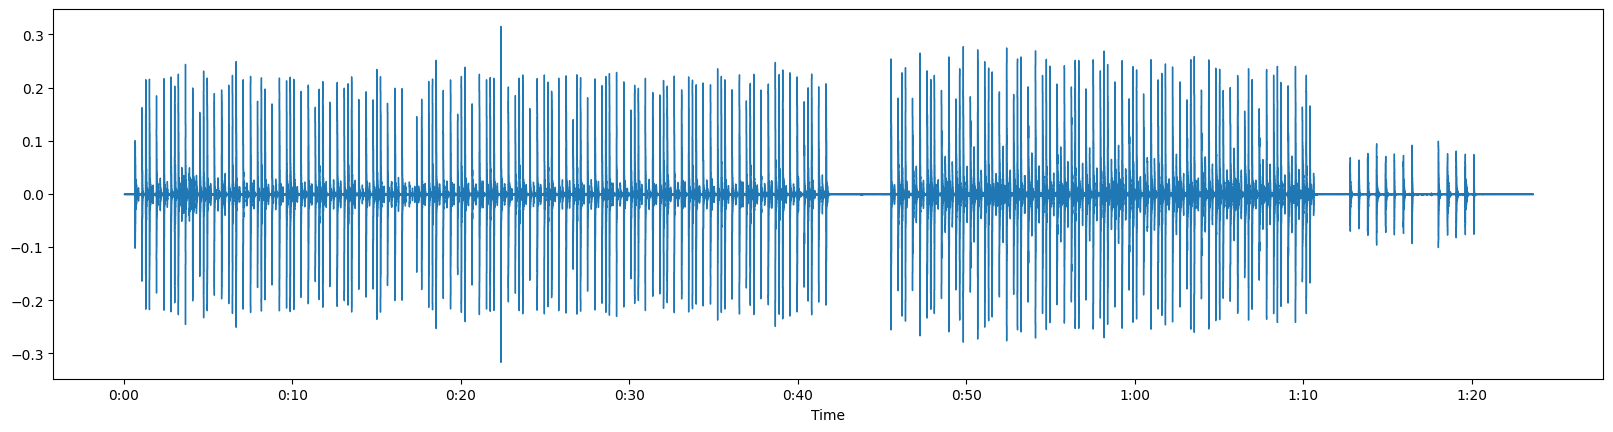

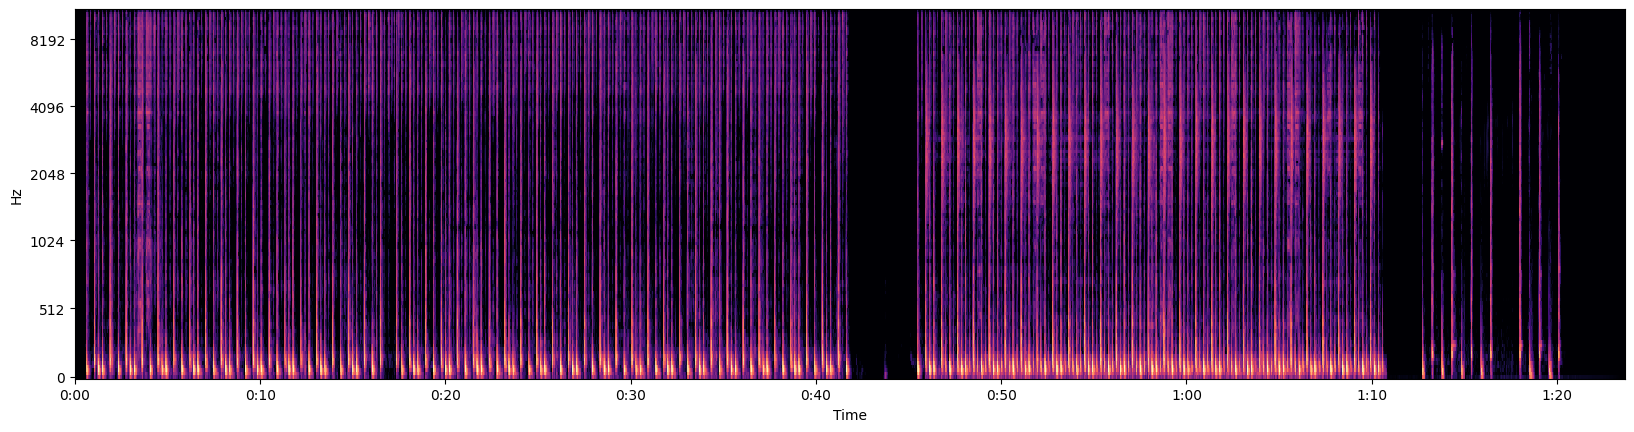

In [95]:
# @markdown ## 1. Choose a driving signal

import matplotlib.pyplot as plt
import keyframed as kf

# TODO: make it easier to specify and featurize a separate audio file for driving audioreactivity

# turn this into a drop down 
driving_signal_name = 'drum stem' # @param {'type':'string'}

custom_signal_fpath = '' # @param {'type':'string'}

#########################################

stems_path = root / "stems"
stems_outpath = stems_path / 'htdemucs_ft' / Path(storyboard.params.audio_fpath).stem
    
def ensure_stems_separated():    
    if not stems_outpath.exists():    
        !demucs -n htdemucs_ft -o {stems_path} "{storyboard.params.audio_fpath}"

def get_stem(instrument_name):
    ensure_stems_separated()
    stem_fpaths  = list(stems_outpath.glob('*.wav'))

    for stem_fpath in stem_fpaths:
        if instrument_name in str(stem_fpath):
            y, sr = librosa.load(stem_fpath)
            return y, sr
    raise ValueError(
        f"Unable to locate stem for instrument: {instrument_name}\n"
        f"in folder: {stems_outpath}"
    )

def get_user_specified_signal():
    y, sr = librosa.load(custom_signal_fpath)
    return y, sr

y = structural_features['y']
sr = structural_features['sr']

driving_signals = {
    'default': lambda: (y, sr),
    'user specified': get_user_specified_signal,
    'vocals stem':lambda: get_stem('vocals'),
    'bass stem':lambda: get_stem('bass'),
    'other stem':lambda: get_stem('other'),
    'drum stem':lambda: get_stem('drum'),
}


driving_signal, sr = driving_signals[driving_signal_name]()

def full_width_plot():
    ax = plt.gca()
    ax.figure.set_figwidth(20)
    plt.show()

def display_signal(y, sr, show_spec=True, title=None):
    librosa.display.waveshow(y, sr=sr)
    if title:
        plt.title(title)
    full_width_plot()
    
    if show_spec:
        try:
            times = librosa.times_like(y, sr=sr)
            M = librosa.feature.melspectrogram(y=y, sr=sr)
            librosa.display.specshow(librosa.power_to_db(M, ref=np.max),
                             y_axis='mel', x_axis='time')
            full_width_plot()

        except:
            pass

display_signal(driving_signal, sr)

### Audio EQ cheat sheet

![Audio EQ cheat sheet](https://i.pinimg.com/736x/4f/28/5e/4f285e3fbc5b6b6ea78638e58b2e3052.jpg)

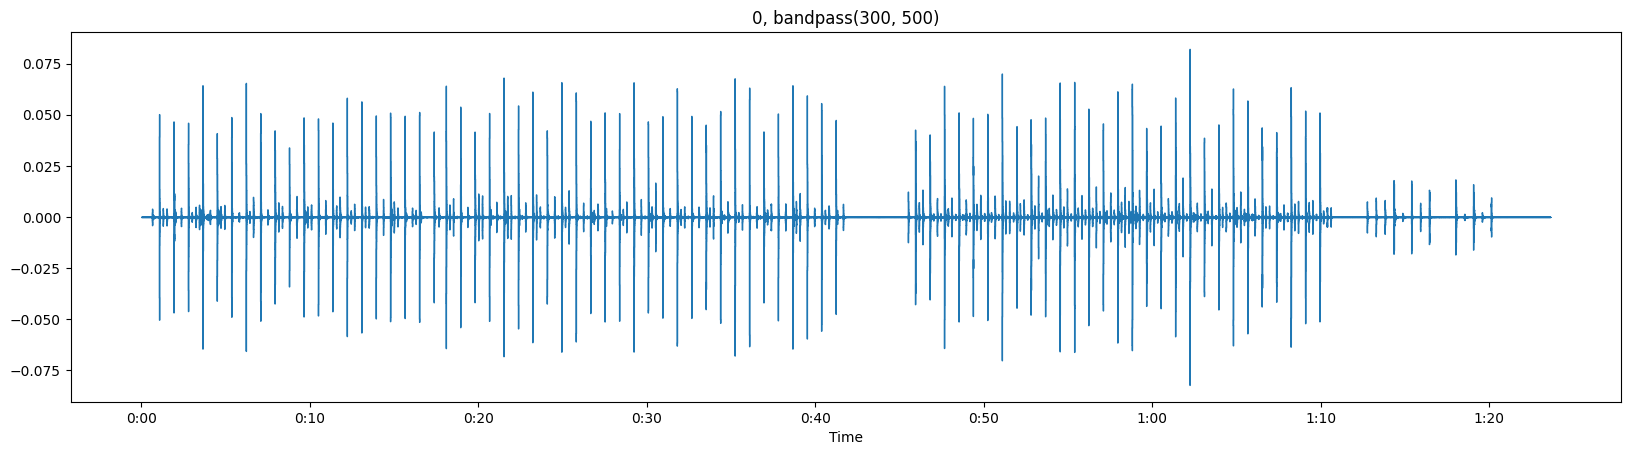

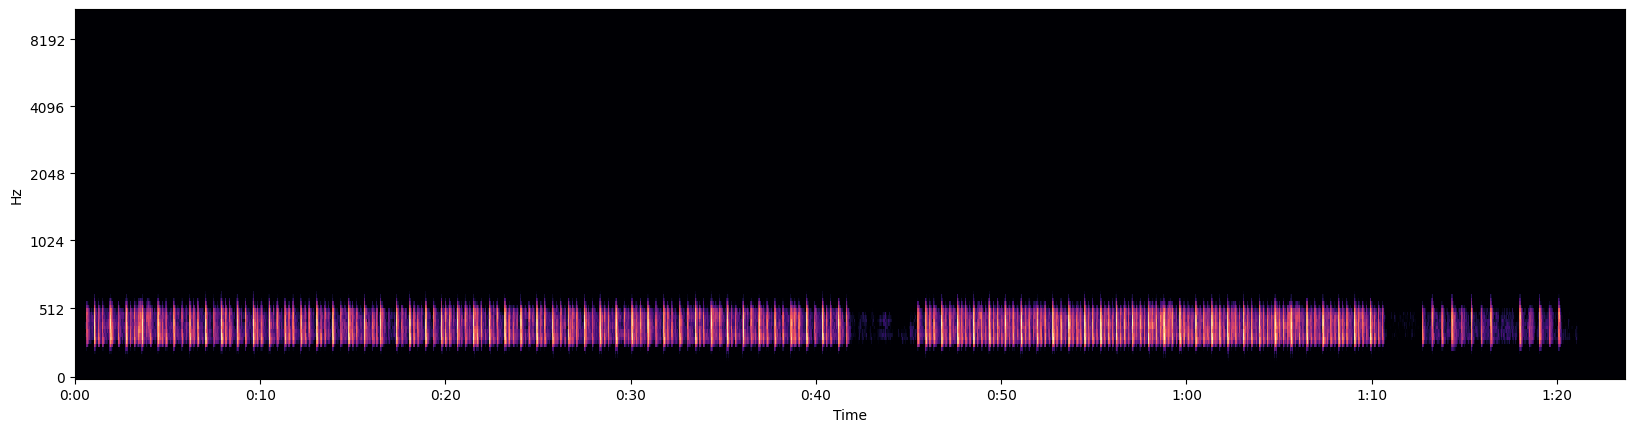

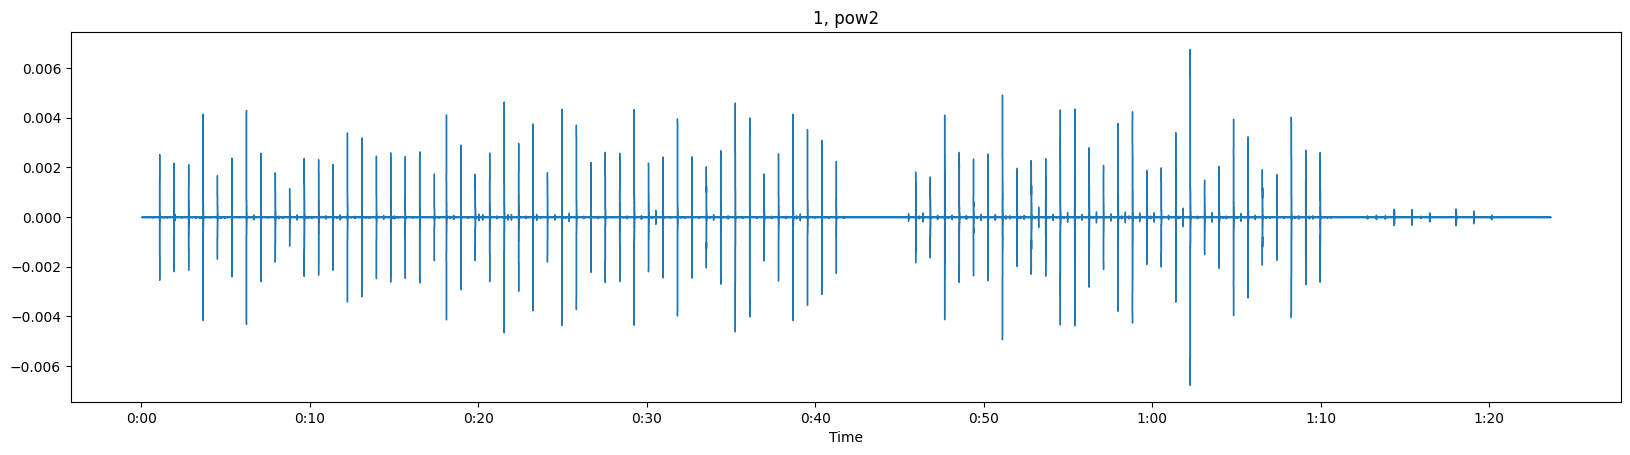

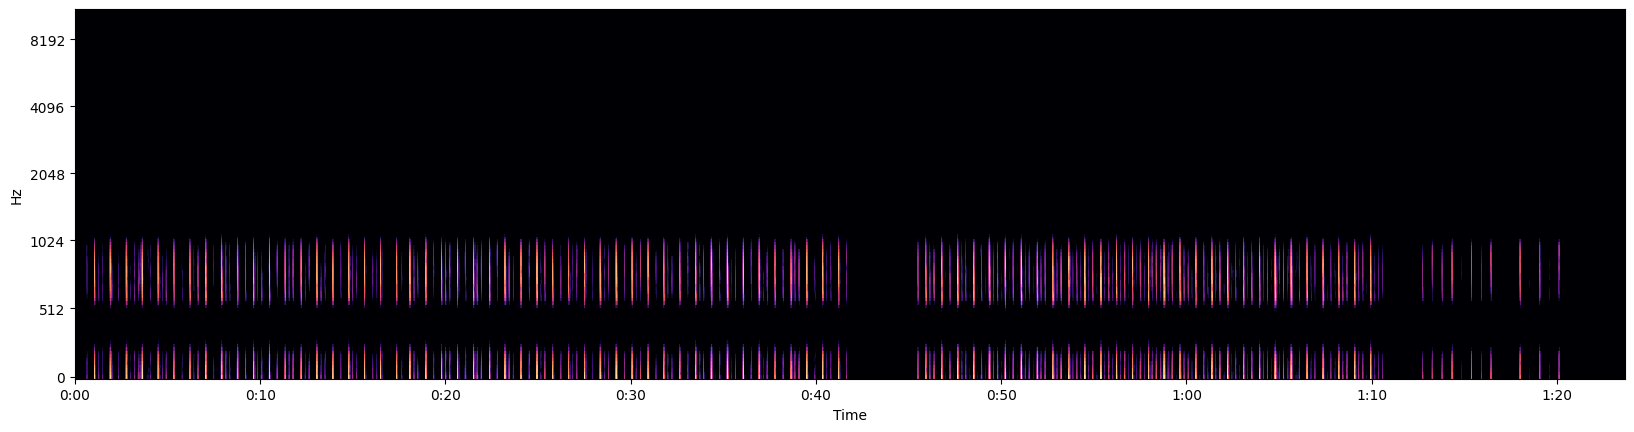

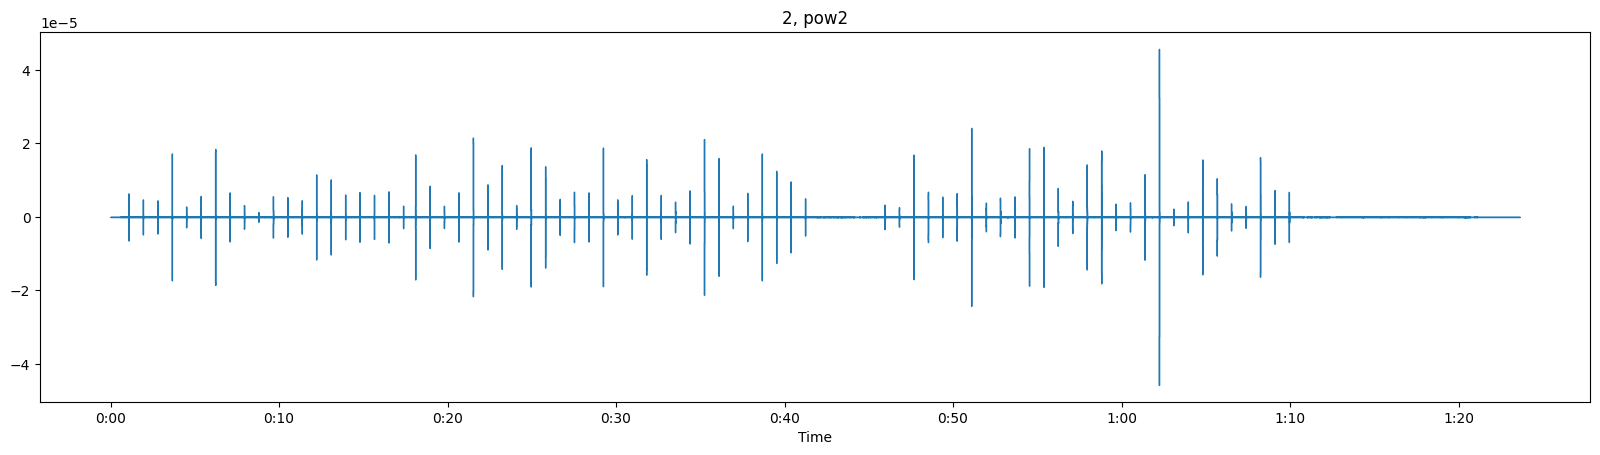

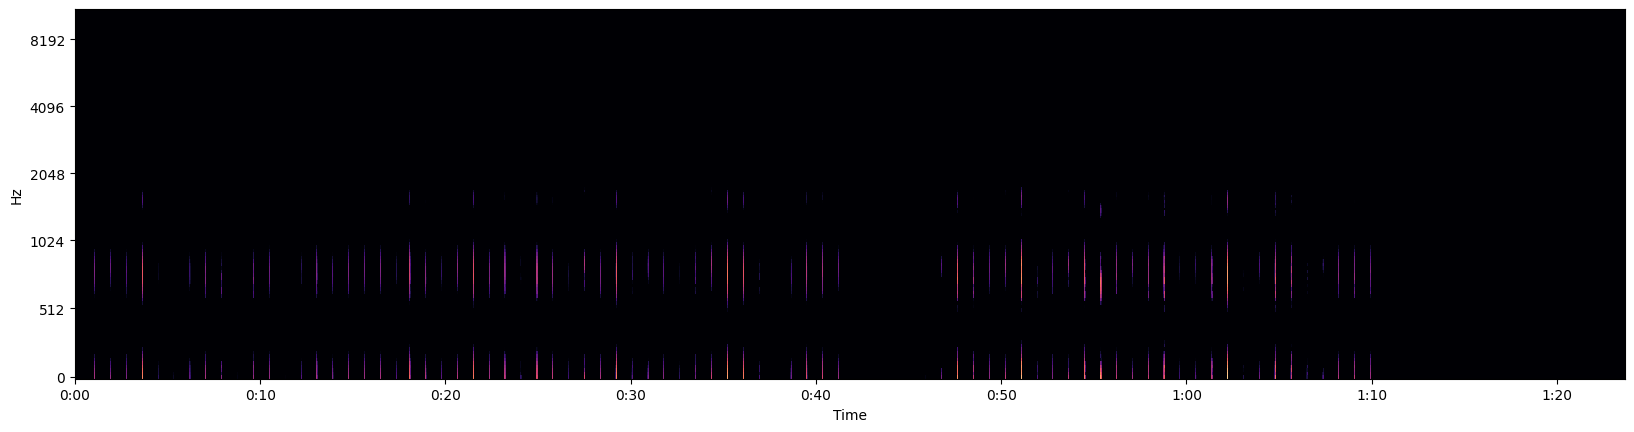

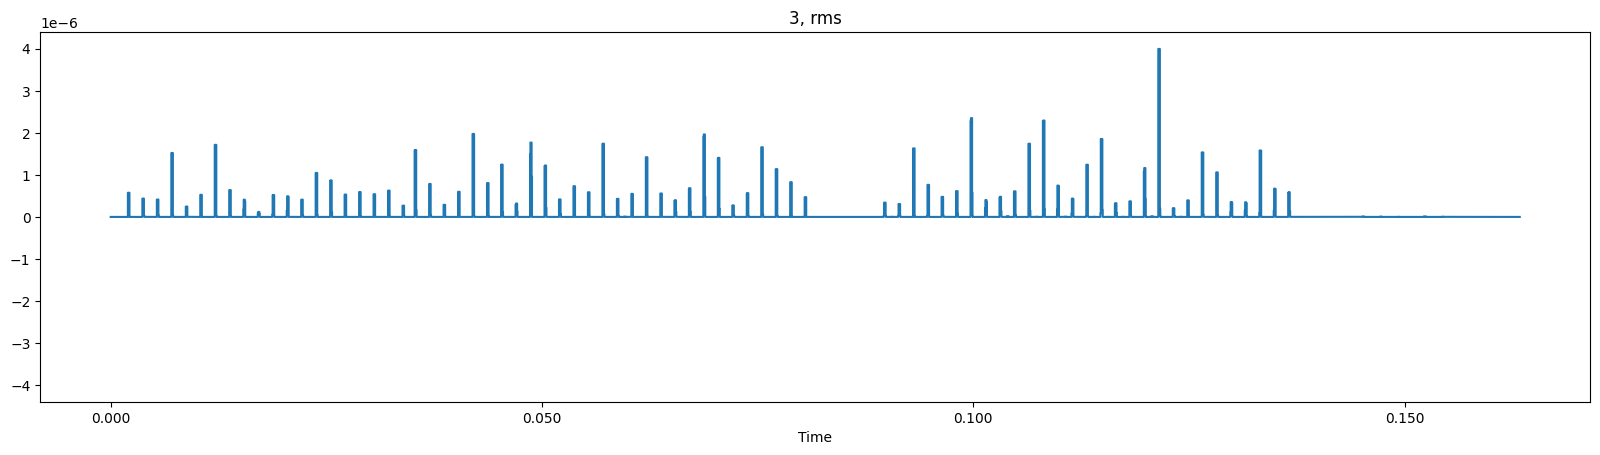

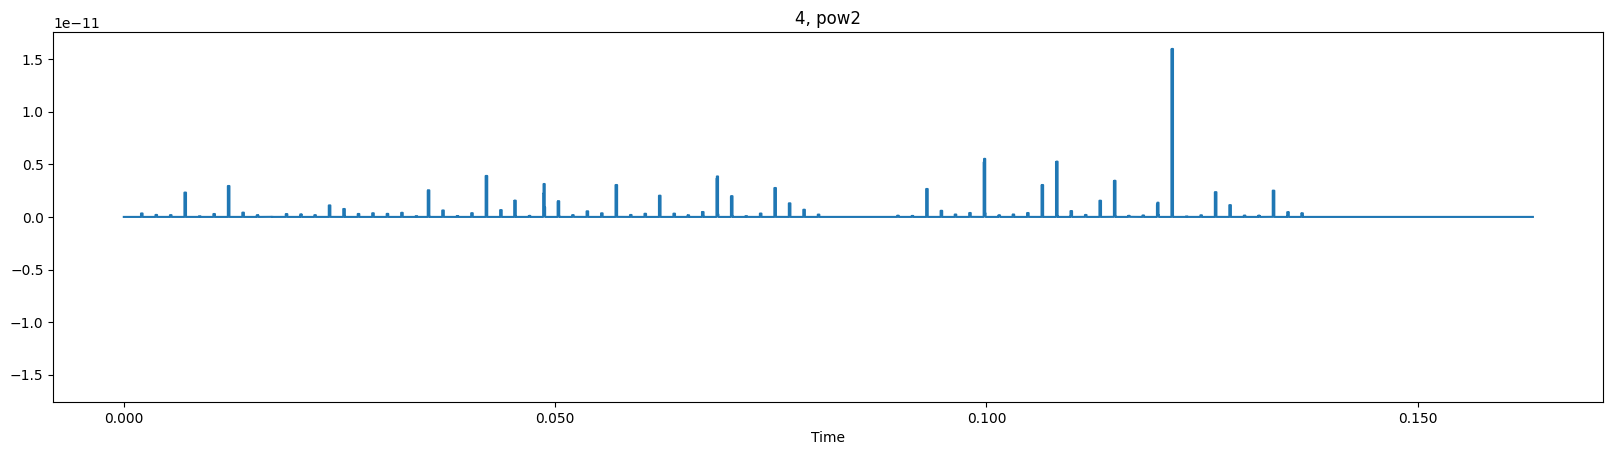

In [96]:
# 2a. Manipulate the signal

# @markdown To apply multiple operations, separate manipulation names with a '|' or just re-run this cell.
# @markdown When you're satisfied, run the next cell to replace the loaded driving signal with the manipulated signal.

# https://github.com/pytti-tools/pytti-core/blob/9e8568365cfdc123d2d2fbc20d676ca0f8715341/src/pytti/AudioParse.py#L95
from scipy.signal import butter, sosfilt, sosfreqz

def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog=False, btype='bandpass', output='sos')
    return sos

def butter_bandpass_filter(data, sr, lowcut, highcut, order=10):
    sos = butter_bandpass(lowcut, highcut, sr, order=order)
    y = sosfilt(sos, data)
    return y

#lower, upper = 1000, 5000
#filtered = butter_bandpass_filter(y, lower, upper, sr, order=5)

# TODO: add operations: threshold(val), clamp(val), quantize(n)
signal_operations = {
    'raw': lambda y, _: y,
    'rms': lambda y, _: librosa.feature.rms(y=y),
    'onset strength': librosa.onset.onset_strength,
    'predominant pulse': librosa.beat.plp,
    'superflux onset': lambda: NotImplementedError, # TODO
    'smoothing': lambda: NotImplementedError, # TODO
    'pow2': lambda y, _: y**2,
    'bandpass':  lambda: KeyError("You should never see this. Please file an issue if you do."),
}

signal_manipulations = 'bandpass(300, 500) | pow2 | pow2 | rms | pow2' # @param {'type':'string'}

manipulations = [m.strip() for m in signal_manipulations.split('|') if m.strip()]

# reset processing
driving_signal_massaged = driving_signal

show_spec=True
for idx, manipulation in enumerate(manipulations):
    if manipulation.startswith('bandpass'):
        filter_params = parse.parse("bandpass({low},{high})", manipulation)
        low, high = float(filter_params['low']), float(filter_params['high'])
        f = lambda y, sr: butter_bandpass_filter(y, sr, low, high)
    else:
        f = signal_operations[manipulation]
    driving_signal_massaged = f(driving_signal_massaged, sr)
    
    # visualize
    if manipulation in ('rms'):
        show_spec=False
    display_signal(driving_signal_massaged, sr, title=f"{idx}, {manipulation}", show_spec=show_spec)


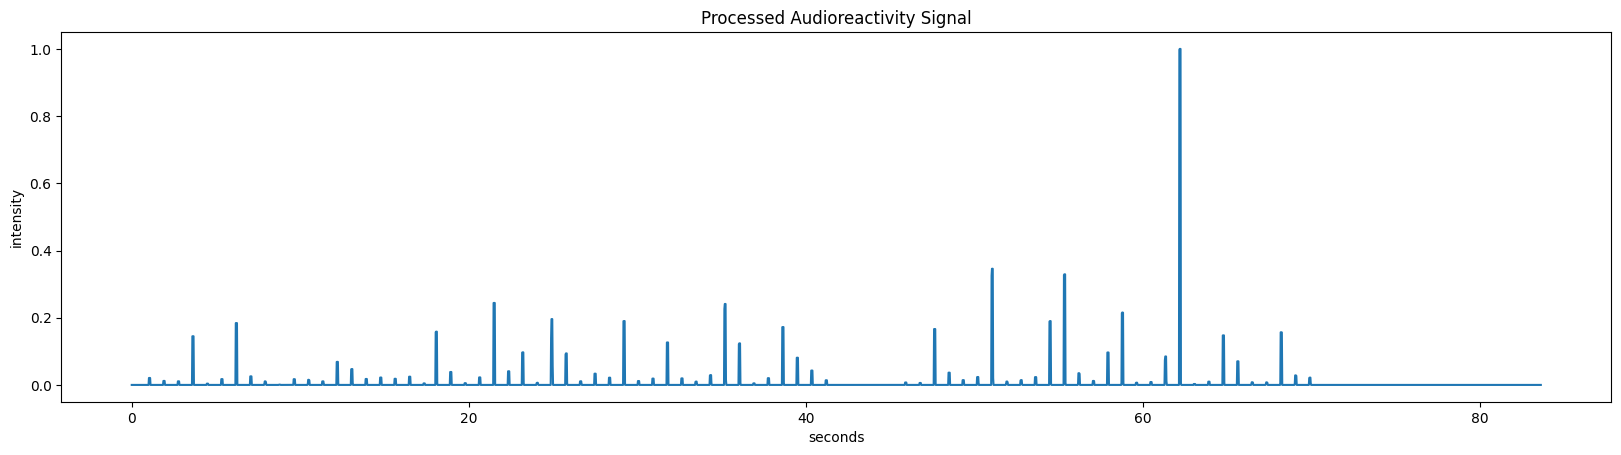

In [97]:
# 2b. Run this cell when you're satisfied with the transformed signal

use_massaged_signal = True # @param {'type':'boolean'}
if use_massaged_signal:
    driving_signal = driving_signal_massaged
    
### Uncomment this snippet to write your driving signal to an audio file
#import soundfile
#soundfile.write('driving_signal.wav', driving_signal, sr)

normalized_signal = np.abs(driving_signal).ravel()
normalized_signal /= max(normalized_signal)

frame_time = librosa.frames_to_time(np.arange(len(normalized_signal)), sr=sr)

driving_signal_kf = kf.Curve({t:v for t,v in zip(frame_time, normalized_signal)})

plt.plot(frame_time, normalized_signal)
plt.xlabel('seconds')
plt.ylabel('intensity')
plt.title("Processed Audioreactivity Signal")
full_width_plot()

In [ ]:
# TODO: add animation reactivity computations to the "math" block,
#       then persist scene-level computed animation arguments back to storyboard

# TODO: Report out cost estimates

# TODO: Let user specify per-scene animation modes

In [105]:
# 3a. Map the driving signal to parameter ranges

signals =[
    dict(
        signal_name = 'noise_reactive',
        attr_hi= .08,
        attr_low = .02,
        inverse_relationship = False,
    ),
    dict(
        attr_hi=.7,
        attr_low = .3,
        inverse_relationship = True,
        signal_name =  'audio_reactive_curve',
    ),
]


# 3b. Map the driving signal to parameter ranges
reactive_signal_map = {
    'audio_reactive_curve':'strength_curve',
    'noise_reactive':'noise_add_curve',
}

# TODO: make the above part more user friendly


##################################################################################################################
##################################################################################################################

# Hi user. You've gone to far. Don't worry about this stuff. Just the bit above the line.

for signal_params in signals:

    attr_hi= signal_params['attr_hi']
    attr_low = signal_params['attr_low']
    inverse_relationship = signal_params['inverse_relationship']
    signal_name = signal_params['signal_name']

    # TODO: instead of attaching the string, let's just build a curve object and use
    #       keyframed.Curve's native serialization. this was the whole point of doing it that way.

    #print(signal_params)

    for scene_idx, rec in enumerate(storyboard.prompt_starts):
        #print(scene_idx)
        if scene_idx == 0:
            prev_rec = rec
            continue
        start, end = prev_rec['start'], rec['start']
        if prev_rec['frames'] < 1:
            continue
            
        curve_chunks = []        
        for frame_idx in range(prev_rec['frames']):
            curr_time = start + frame_idx * ifps
            signal_value = driving_signal_kf[curr_time]
            if inverse_relationship:
                signal_value = 1-signal_value
            attr_value = signal_value*(attr_hi-attr_low)+attr_low
            #curve_chunks.append(f"{curr_time-start}:({attr_value})")
            curve_chunks.append(f"{frame_idx}:({attr_value})")
        curve_str = ','.join(curve_chunks)
        prev_rec[signal_name] = curve_str
        prev_rec = rec
    else: # hate this.
        #start, end = prev_rec['start'], rec['start']
        #if prev_rec['frames'] < 1:
        #    continue
        start, end = rec['start'], rec['end']
        if rec['frames'] > 0:
            curve_chunks = []
            for frame_idx in range(rec['frames']):
                curr_time = start + frame_idx * ifps
                signal_value = driving_signal_kf[curr_time]
                if inverse_relationship:
                    signal_value = 1-signal_value
                attr_value = signal_value*(attr_hi-attr_low)+attr_low
                #curve_chunks.append(f"{curr_time-start}:({attr_value})")
                curve_chunks.append(f"{frame_idx}:({attr_value})")
            curve_str = ','.join(curve_chunks)
            #prev_rec[signal_name] = curve_str
            rec[signal_name] = curve_str


with open(storyboard_fname) as fp:
    OmegaConf.save(config=storyboard, f=fp.name)

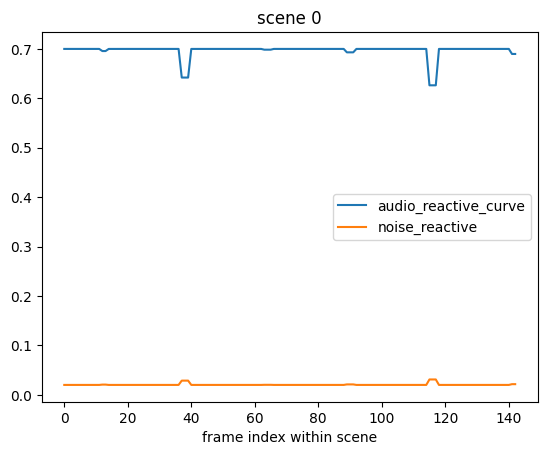

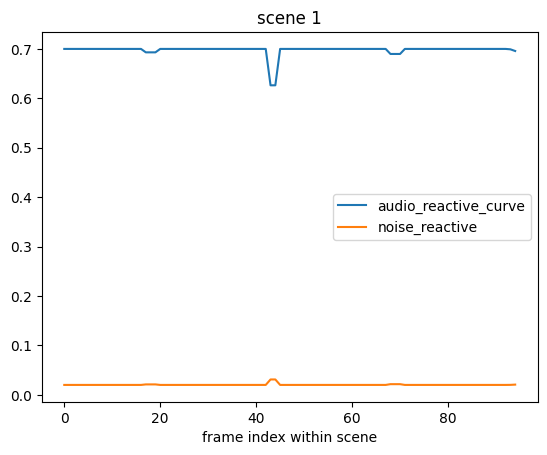

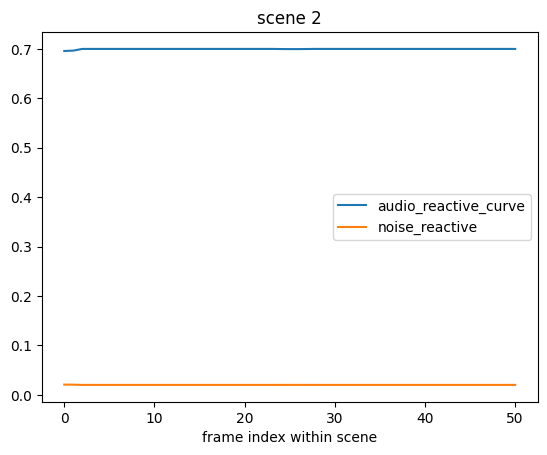

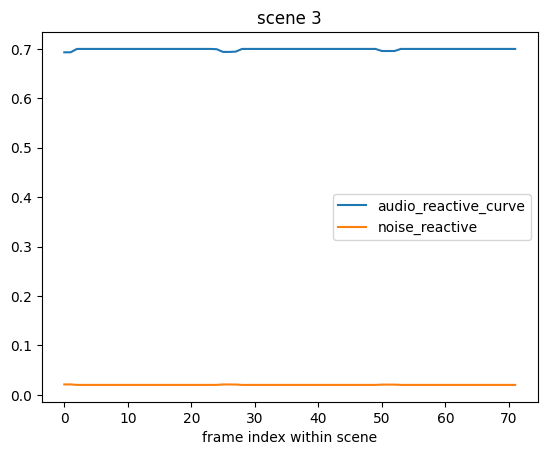

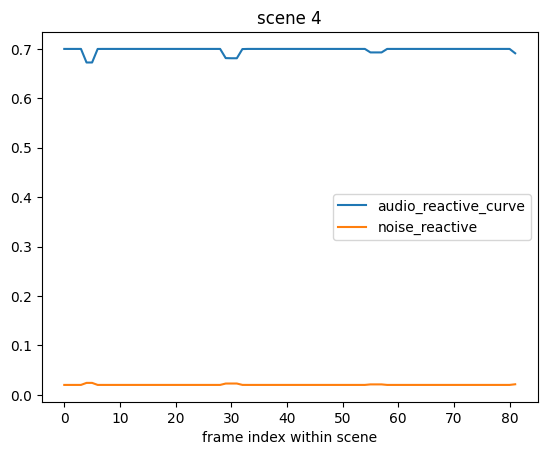

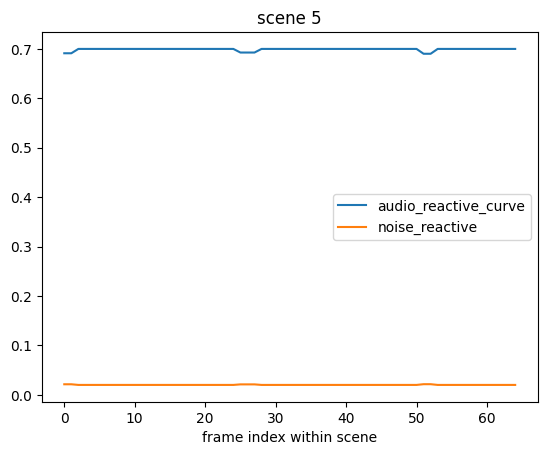

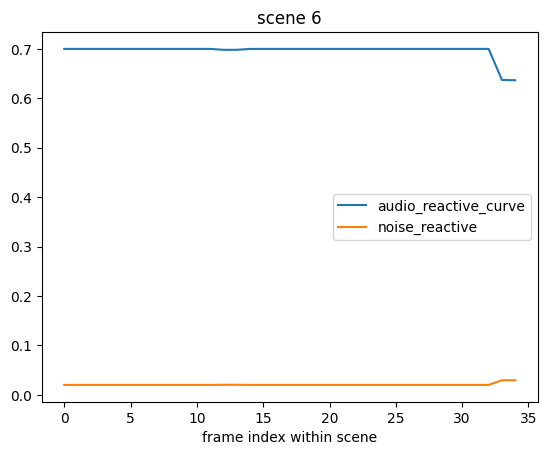

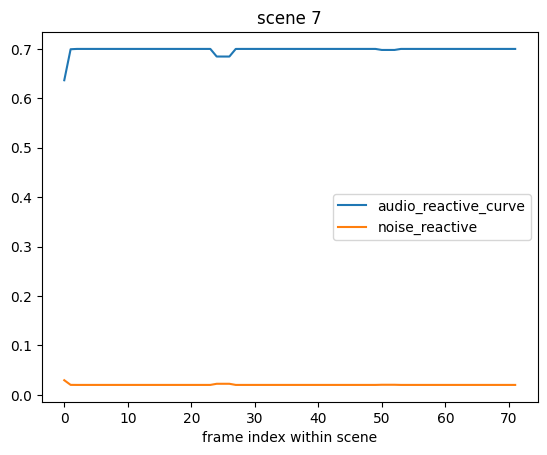

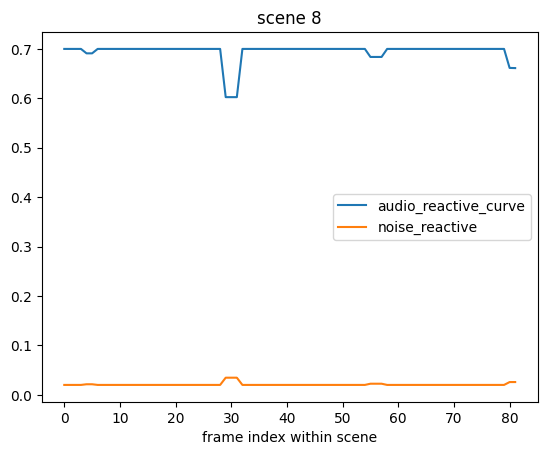

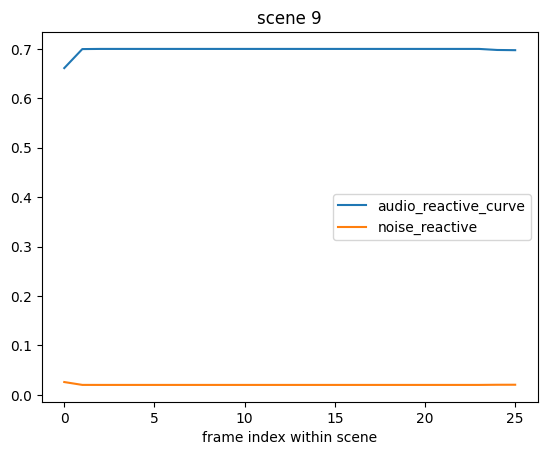

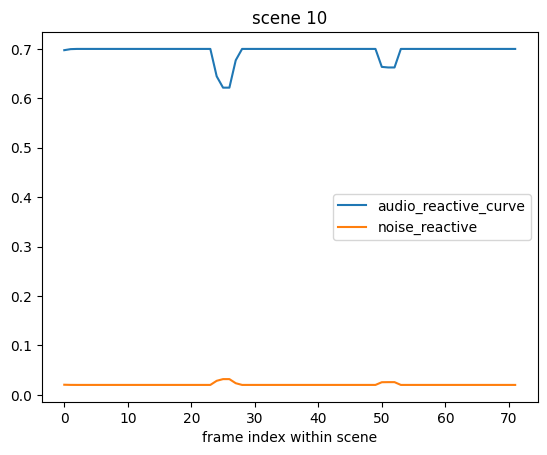

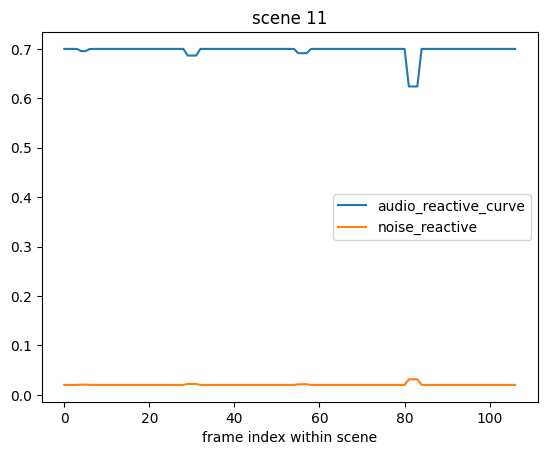

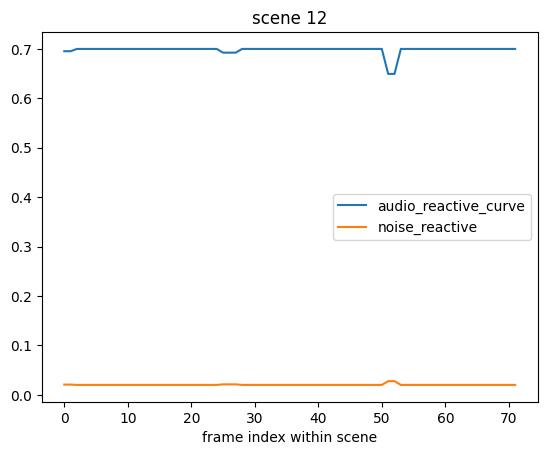

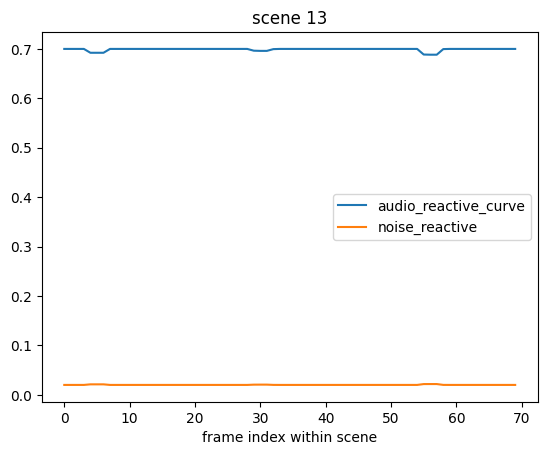

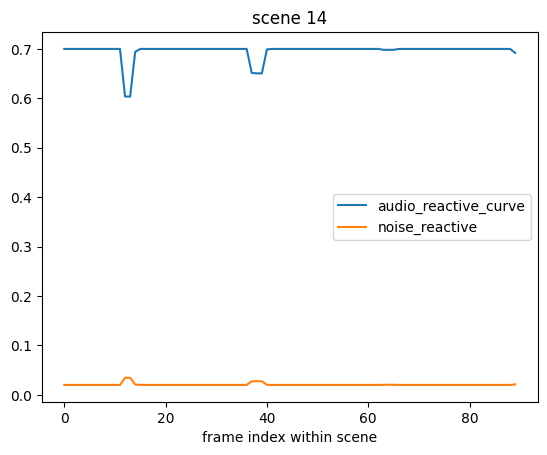

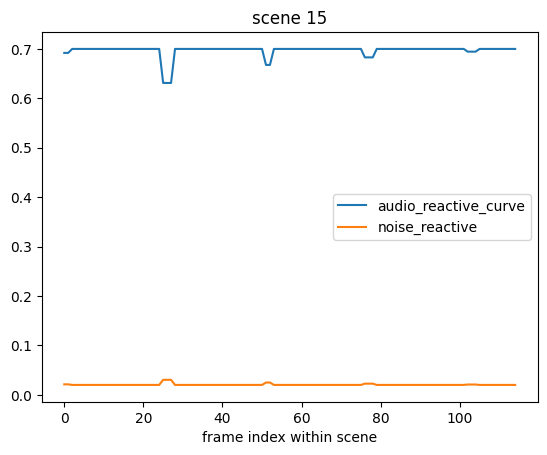

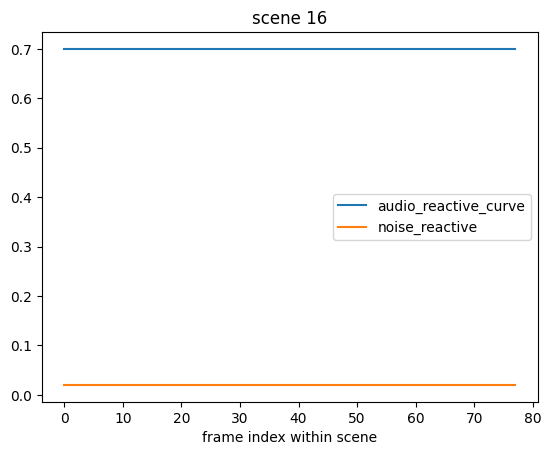

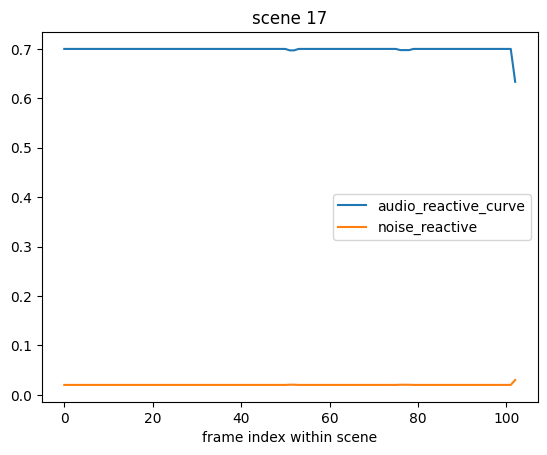

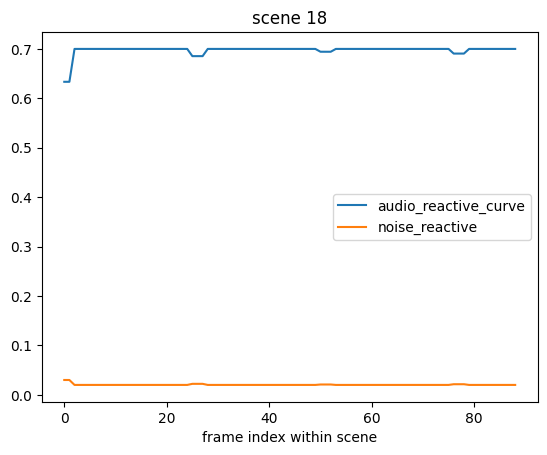

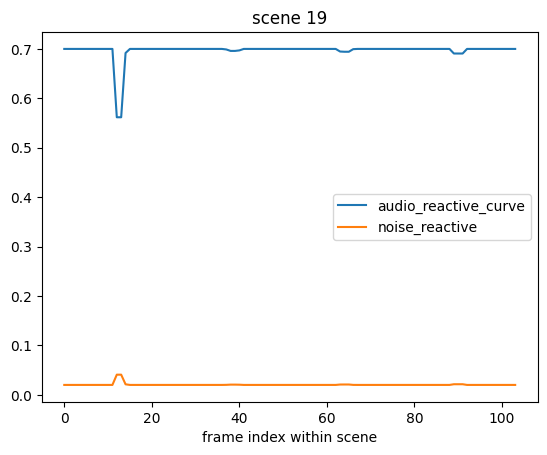

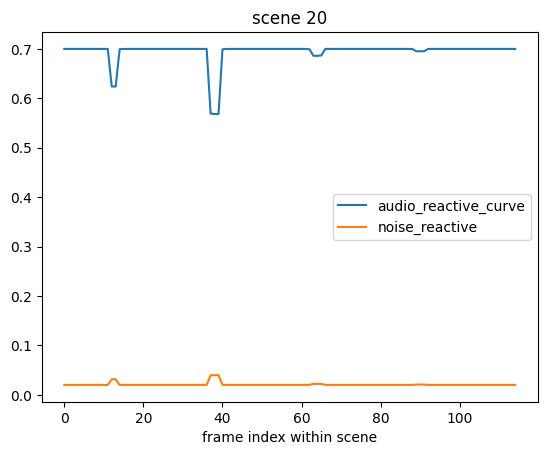

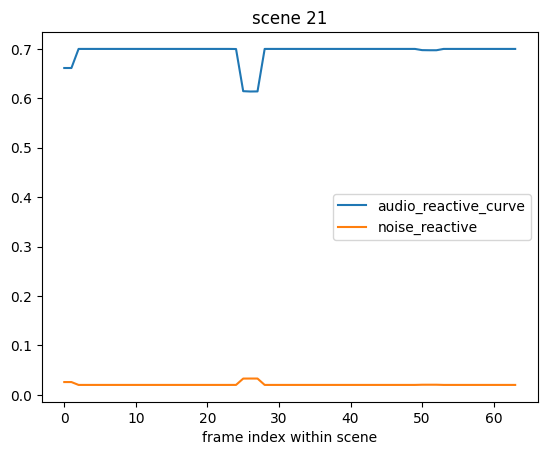

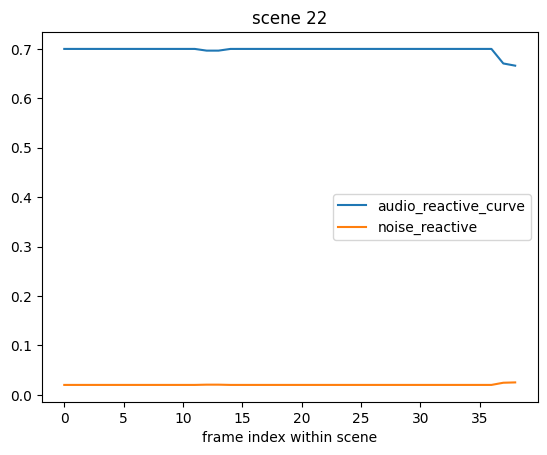

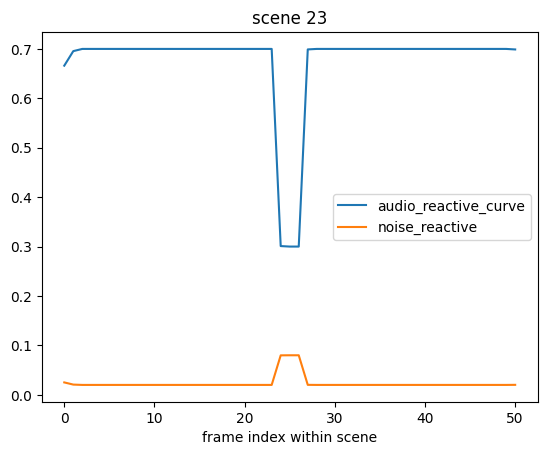

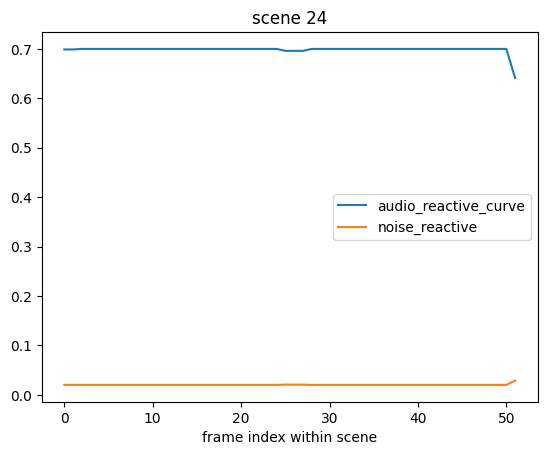

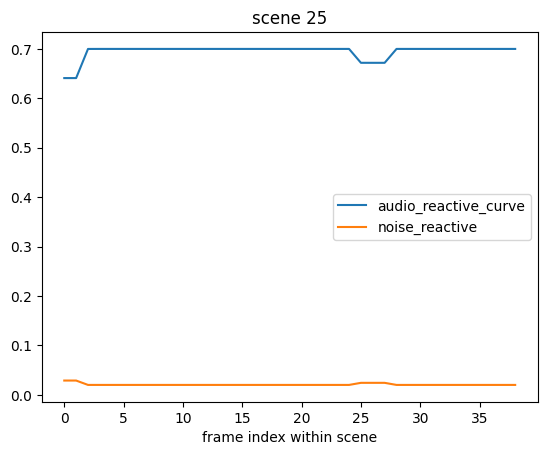

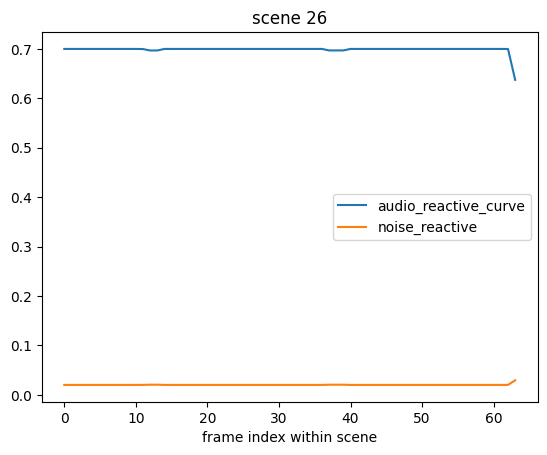

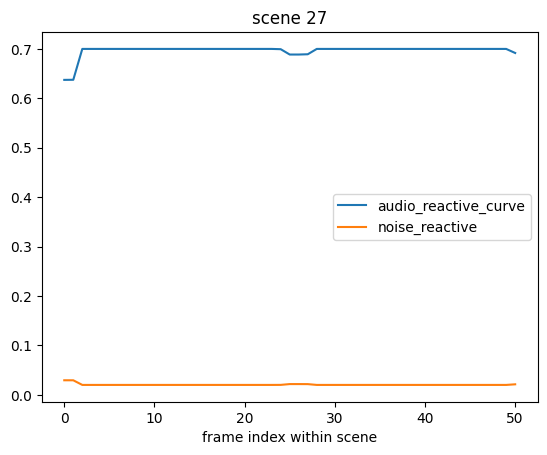

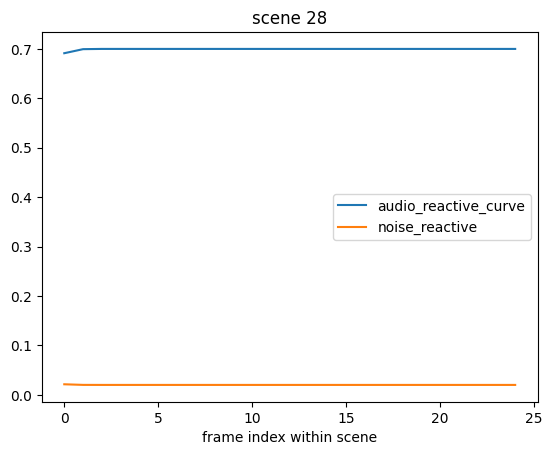

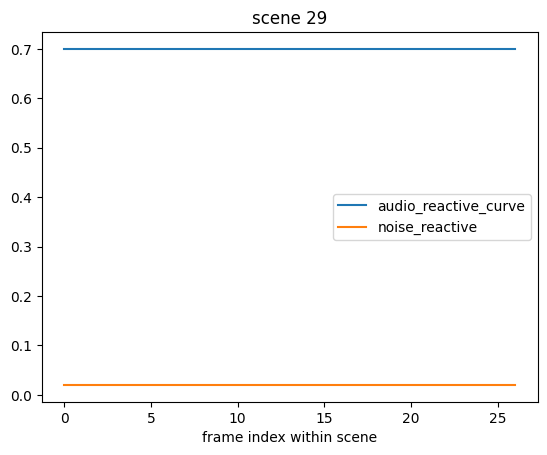

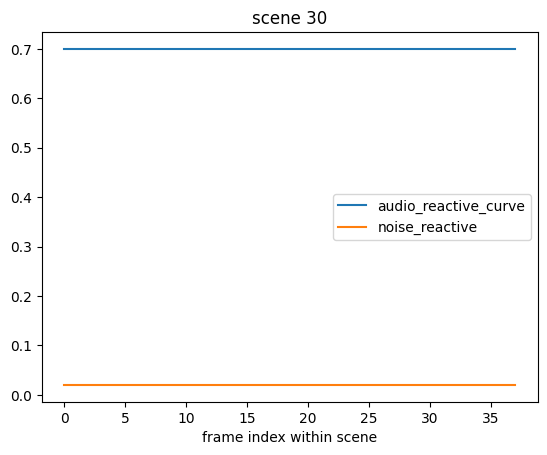

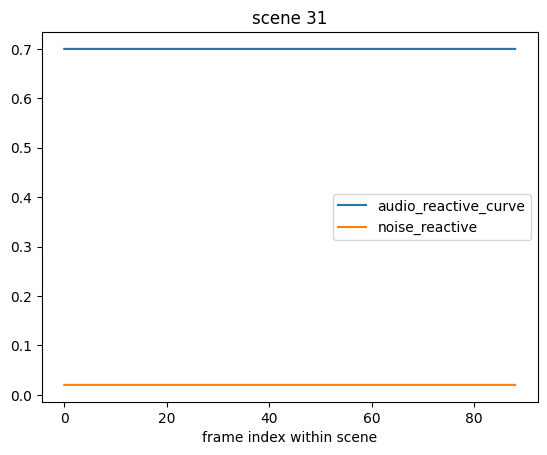

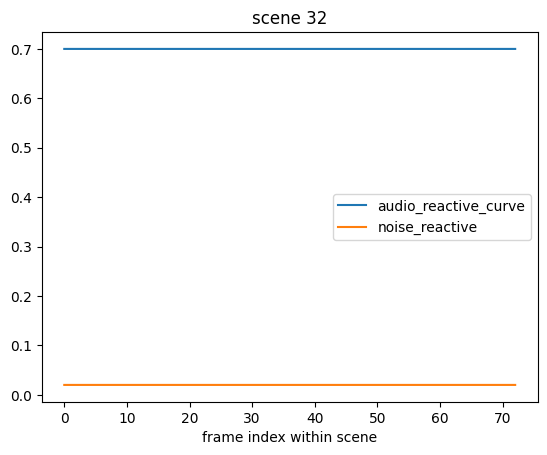

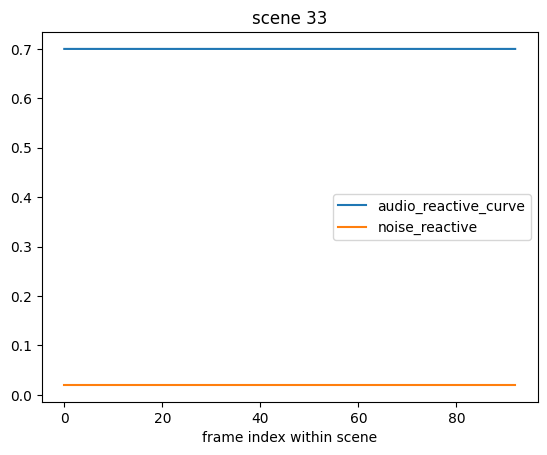

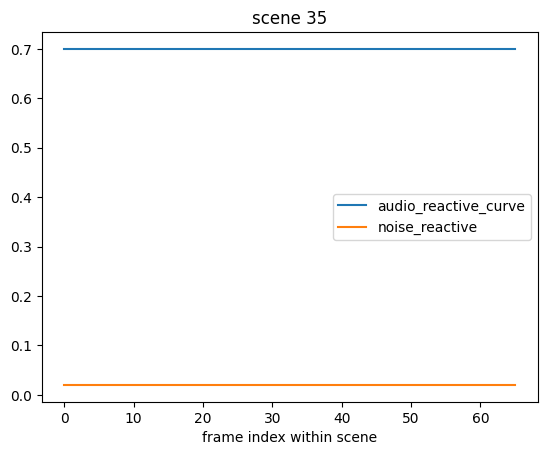

In [106]:
# Optional: show per-scene reactivity

for idx, rec in enumerate(storyboard.prompt_starts):
    n = rec['frames']
    if n <1:
        continue
    for signal_name in reactive_signal_map.keys():
        if signal_name in rec:
            curve = kf.dsl.curve_from_cn_string(rec[signal_name])
            xs = [i for i in range(n)]
            ys = [curve[i] for i in xs]
            plt.plot(xs, ys, label=signal_name)
        plt.title(f"scene {idx}")
        plt.xlabel("frame index within scene")
        plt.legend()
    plt.show()
    

## $3.$ 🎬 Animate

In [ ]:
#####################################
# @title ## 🎨 Generate init images
#####################################


prompt_starts = storyboard.prompt_starts
use_stability_api = workspace.use_stability_api
model_dir = workspace.model_dir

device = 'cuda'
model_id = "CompVis/stable-diffusion-v1-5"
download=True

model_dir = workspace.model_dir
model_path= str(Path(model_dir) / 'huggingface' / 'diffusers')


if 'get_image_for_prompt' not in locals():

    if use_stability_api:
        import warnings
        from stability_sdk import client
        import stability_sdk.interfaces.gooseai.generation.generation_pb2 as generation


        def get_image_for_prompt(prompt, max_retries=5, **kargs):
            return get_image_for_prompt_sai(prompt, max_retries=5, **kargs)


        # leverage stability API internal parallelism for batch variation requests
        # TODO: make sure this behaves appropriately for regeneration on NSFW trigger. only regen as needed, not whole batch
        def get_variations_w_init(prompt, init_image, n_variations=2, image_consistency=.7, **kargs):
             return list(
                 get_image_for_prompt(
                     prompt=prompt, 
                     init_image=init_image, 
                     start_schedule=(1-image_consistency), 
                     #num_samples=n_variations,
                     samples=n_variations,
                     **kargs,
                 )
             )
                        
    else:

        if download:
            img2img = StableDiffusionImg2ImgPipeline.from_pretrained(
                model_id,
                revision="fp16", 
                torch_dtype=torch.float16,
                use_auth_token=True
            )
            img2img = img2img.to(device)
            img2img.save_pretrained(model_path)
        else:
            img2img = StableDiffusionImg2ImgPipeline.from_pretrained(
                model_path,
                local_files_only=True
            ).to(device)

        text2img = StableDiffusionPipeline(
            vae=img2img.vae,
            text_encoder=img2img.text_encoder,
            tokenizer=img2img.tokenizer,
            unet=img2img.unet,
            feature_extractor=img2img.feature_extractor,
            scheduler=img2img.scheduler,
            safety_checker=img2img.safety_checker,
        )
        text2img.enable_attention_slicing()
        img2img.enable_attention_slicing()


        def get_image_for_prompt_hf(
            prompt,
            **kwargs
        ):
            f = text2img if kwargs.get('image') is None else img2img
            n_retries = 5
            with autocast(device):
                while n_retries > 0:
                    n_retries-=1
                    result = f(prompt, **kwargs)
                    if not any(result.nsfw_content_detected):
                        return result.images
                    else:
                        print(f"nsfw content detectected. retries remaining: {n_retries}")

        def get_image_for_prompt(*args, **kargs):
            if 'init_image' in kargs:
                kargs['image'] = kargs.pop('init_image')
            if 'start_schedule' in kargs:
                kargs['strength'] = kargs.pop('start_schedule')
            return get_image_for_prompt_hf(*args, **kargs)

        # TODO: (HF) request multiple images in single request
        def get_variations_w_init(prompt, init_image, **kargs):
            return list(get_image_for_prompt(prompt=prompt, init_image=init_image, **kargs))


##################
##  PARAMETERS  ##
##################

d_ = dict(
    _=''
    , height = 512 # @param {type:'integer'}
    , width = 512 # @param {type:'integer'}
    # TODO: pretty sure can delete this
    #, display_frames_as_we_get_them = True # @param {type:'boolean'}
)
d_.pop('_')

#regenerate_all_init_images = True # @param {type:'boolean'}
regenerate_all_init_images = False # @param {type:'boolean'}

# TODO: make this an integer
prompt_lag = True # @param {type:'boolean'}

# @markdown `prompt_lag` - Extend prompt with lyrics from previous frame. Can improve temporal consistency of narrative. 
# @markdown  Especially useful for lyrics segmented into short prompts.

#TODO: check from storyboard

# regenerate all images if the theme prompt has changed or user specifies
#if d_['theme_prompt'] != storyboard.params.get('theme_prompt'):
#    regenerate_all_init_images = True


storyboard.params.update(d_)

if regenerate_all_init_images:
    for i, rec in enumerate(prompt_starts):
        rec['frame0_fpath'] = None
        archive_images(i, root=root)
    print("archival process complete")

# anchor images will be regenerated if there's no associated frame0_fpath
# regenerate specific images if
# * manually tagged by user in df_regen
# * associated fpath doesn't exist (i.e. deleted)
# TODO: dump df_regen stuff
# TODO: move archival stuff...
if 'df_regen' in locals():
    for i, _ in df_regen.iterrows():
        rec = prompt_starts[i]
        regen = not _['keep']
        # need to check this elsewhere
        if rec.get('frame0_fpath') is None:
            regen = True
        elif not Path(rec['frame0_fpath']).exists():
            regen=True
        if regen:
            rec['frame0_fpath'] = None
            print(rec)
            archive_images(i, root=root)
    print("archival process complete")


theme_prompts = storyboard.params.theme_prompt
height = storyboard.params.height
width = storyboard.params.width

proj_name = workspace.active_project


## Main loop ##

print("Ensuring each prompt has an associated image")
for idx, rec in enumerate(prompt_starts):
    #print(idx, rec)
    theme = rec.get('_theme')
    prompt = rec.get('prompt')
    if not prompt:
        prompt = f"{rec['text']}, {theme}"
    
        if prompt_lag and (idx > 0):
            rec_prev = prompt_starts[idx -1]
            prev_text = rec_prev.get('text')
            if not prev_text:
                prev_text = rec_prev.get('prompt').split(',')[0]
            this_text = rec.get('text')
            if this_text:
                prompt = f"{prev_text} {this_text}, {theme}"
            else:
                prompt = rec_prev['_prompt']
    rec['_prompt'] = prompt
    
    print(
        f"scene: {idx}\t time: {rec['start']}\n"
        f"spoken text: {rec.get('text')}\n"
        f"image prompt: {rec['_prompt']}\n"
    )
    if rec.get('frame0_fpath') is None:
        init_image = list(get_image_for_prompt(
              rec['_prompt'],
              height=height,
              width=width,
              )
          )[0]
    # this shouldn't be necessary, but is a consequence of
    # the globbing thing we're doing atm
    if 'anchor' not in str(rec.get('frame0_fpath')):
        # TODO: save_frame doesn't need to be a function.
        rec['frame0_fpath'] = save_frame(
            init_image,
            idx,
            root_path = root / 'frames',
            name='anchor',
            )

        print(rec.get('text'))
        display(init_image)

# TODO: regen picks up at first frame that needs it correctly, 
#       but then continues on overwriting all subsequent frames.
#       Fix it to regain ability to delete specific init images to have just those regened

##############
# checkpoint #
##############

# TODO: recognize previous generations

storyboard.prompt_starts = prompt_starts

with open(storyboard_fname) as fp:
    OmegaConf.save(config=storyboard, f=fp.name)

In [ ]:
# For outputting a storyboard for ChatGPT prompting

# import rich
# import json
# #rich.print(dict(storyboard))

# outter_cols = ['audio_fpath','video_duration']

# cols = ['start','text', 'structural_segmentation_label'] #,'no_speech_prob','avg_logprob','compression_ratio']
# recs = [{k:rec[k] for k in cols} for rec in storyboard['prompt_starts'] if rec.get('inferred_subscene') is None]
# recs = [{k:storyboard.params[k]} for k in outter_cols] + recs
# rich.print(recs)

In [ ]:

# TODO: wrap this in its own animation mode
# - ~~`variations (vktrs legacy)` maybe?~~
# - variations
# - variations tsp

# @title ## 🚀 Generate animation frames

# (variation animations)

##################################
# Generate animation frames #
##################################

d_ = dict(
    _=''
    , n_variations=8 # @param {type:'integer'}
    , image_consistency=0.72 # @param {type:"slider", min:0, max:1, step:0.01}  
    , max_video_duration_in_seconds = 300 # @param {type:'integer'}
)
d_.pop('_')


# @markdown `fps` - Frames-per-second of generated animations

# @markdown `n_variations` - How many unique variations to generate for a given text prompt. This determines the frequency of the visual "pulsing" effect

# @markdown `image_consistency` - controls similarity between images generated by the prompt.
# @markdown - 0: ignore the init image
# @markdown - 1: true as possible to the init image

# @markdown `max_video_duration_in_seconds` - Early stopping if you don't want to generate a video the full duration of the provided audio. Default = 5min.


storyboard.params.update(d_)
storyboard.params.max_frames = storyboard.params.fps * storyboard.params.max_video_duration_in_seconds

image_consistency = storyboard.params.image_consistency
max_frames = storyboard.params.max_frames
n_variations = storyboard.params.n_variations


# load init_images and generate variations as needed
print("Fetching variations")
for idx, rec in enumerate(prompt_starts):
    new_images = []
    images_fpaths = get_image_sequence(idx, root=root)
    curr_variation_count = len(images_fpaths)
    print(f"curr_variation_count:{curr_variation_count}")
    if curr_variation_count < n_variations:
        prompt = rec['_prompt']

        init_image = Image.open(rec['frame0_fpath'])
        # TODO: user should be able to specify basically anything per-entry
        # next line is here to permit user to specify more variations for a specific entry
        tot_variations = rec.get('n_variations', n_variations)
        tot_variations = min(tot_variations, rec['frames']) # don't generate variations we won't use
        print(f"tot_variations:{tot_variations}")
        tot_variations -= curr_variation_count  # only generate variations we still need
        print(f"tot_variations to request:{tot_variations}")
        
        # why do we have a scene with 0 frames? something funny with start times overlapping i think.
        # seems like the subsegmentation thing didn't fully update this part properly?
        if tot_variations < 1:
            continue
        
        image_variations = get_variations_w_init(
            prompt=prompt, 
            init_image=init_image, 
            image_consistency=image_consistency,
            n_variations=tot_variations,
        )
        for img in image_variations:
            save_frame(
                img,
                idx,
                root_path= root / 'frames',
            )

            display(img)

                
##############
# checkpoint #
##############

storyboard.prompt_starts = prompt_starts

with open(storyboard_fname) as fp:
    OmegaConf.save(config=storyboard, f=fp.name)

# @markdown ---
# @markdown Running this cell will generate as many variation frames as required 
# @markdown per `n_variations`. To trigger regeneration of images that didn't
# @markdown generate correctly (e.g. because a nsfw classifier was triggered),
# @markdown just delete those images.

In [ ]:
# fancy new animation


#for frame in tqdm(animator.render(), initial=animator.start_frame_idx, total=args.max_frames):
#    display.clear_output(wait=True)
#    display.display(frame)
    
#animator.save_settings(f"{timestring}_settings.txt")
#args.fps
#args.seed
#args.max_frames


negative_prompt = ''
negative_prompt_weight = -1


#animator = get_animator(prompt, n_frames, init_image_fpath)

from keyframed import SmoothCurve

# TODO: stop doing this. it creates bugs. just write the whole thing out when you need it.
prompt_starts = storyboard.prompt_starts


print("Fetching variations")
for idx, rec in enumerate(prompt_starts):
    new_images = []
    images_fpaths = get_image_sequence(idx, root=root)
    images_fpaths = sorted(images_fpaths, key=os.path.getmtime)
    
    curr_variation_count = len(images_fpaths)
    print(f"curr_variation_count:{curr_variation_count}")
    n_variations = rec['frames']
    if curr_variation_count < n_variations:
        prompt = rec['_prompt']

        #init_image = Image.open(rec['frame0_fpath'])
        init_image_path = images_fpaths[-1]
        
        
        # TODO: user should be able to specify basically anything per-entry
        # next line is here to permit user to specify more variations for a specific entry
        tot_variations = rec.get('n_variations', n_variations)
        tot_variations = min(tot_variations, rec['frames']) # don't generate variations we won't use
        print(f"tot_variations:{tot_variations}")
        tot_variations -= curr_variation_count  # only generate variations we still need
        print(f"tot_variations to request:{tot_variations}")
        
        # why do we have a scene with 0 frames? something funny with start times overlapping i think.
        # seems like the subsegmentation thing didn't fully update this part properly?
        if tot_variations < 1:
            continue
        
        # image_variations = get_variations_w_init(
        #     prompt=prompt, 
        #     init_image=init_image, 
        #     image_consistency=image_consistency,
        #     n_variations=tot_variations,
        # )
        # for img in image_variations:
        #     save_frame(
        #         img,
        #         idx,
        #         root_path= root / 'frames',
        #     )
        
        ##############################
        
        # grab baseline animation args from UI
        args_d = {}
        [args_d.update(a.param.values()) for a in arg_objs]
        args=AnimationArgs(**args_d)
        
        # set major args based on theme label
        # use modulo of idx to toggle options
        sign = (-1)**(idx%2)
        theme_id = rec['structural_segmentation_label']
        #value = sign * (theme_id+1) * 0.1
        value = sign * 0.1
        args.translation_x = f"0:({value})"
        args.rotation_y = f"0:({-value})"

        args.max_frames = tot_variations
        args.fps = storyboard.params.fps
        args.init_image = init_image_path
        animation_prompts = {0:prompt}
        
        # to do: modularize this better. 
        # really just need a mapping dict to iterate over
        #args.strength_curve = rec['audio_reactive_curve']
        #args.noise_add_curve = rec['noise_reactive']
        
        # not sure if this'll work, but it'd be nice if it did
        for k,v in reactive_signal_map.items():
            setattr(args, v, rec[k])
        
        animator = Animator(
            api_context=context,
            animation_prompts=animation_prompts,
            args=args,
            out_dir=None, #out_dir,    
            negative_prompt=negative_prompt,
            negative_prompt_weight=negative_prompt_weight,
            resume=len(resume_timestring) != 0)

        #im_paths = []
        im_paths = images_fpaths[:]
        #j=0 # not super resume friendly
        for img in tqdm(animator.render(), initial=animator.start_frame_idx, total=args.max_frames):
            from IPython.display import clear_output
            #display.clear_output(wait=True)
            #display.display(frame)
            clear_output(wait=True)
            display(img)
            new_frame_fpath = save_frame(
                img, idx, root_path=root/'frames',
                name=f"{tot_variations}" # it'll be reversed, but it's not nothing
            )
            tot_variations-=1
            im_paths.append(new_frame_fpath)
        rec['frame_order'] = im_paths

        # checkpoint ?

# TODO: parallelize generations across scenes. 
#       i.e. maybe it's non trivial to parallelize generations within a scene,
#       but we can do several scenes in parallel. need more control over how
#       the animator constructs/emits requests. want it to construct requests
#       for several scenes, then multiplex the request objects into a single
#       larger request, which would then need to have responses demuxed

# TODO: max-binning/aggregation (sync) functionality for keyframed
#       ... or is this something it already supports?
# TODO: [keyframed] lag aggregation

In [ ]:
# @title ## 📺 Compile your video and enjoy your animation!

# to do: skip tsp if n_variations ==1

# TODO: change frame-write names so this will be cmopatible with an ffmpeg one-liner to generate preview animations
# TODO: add a rec['cumulative frames'] or something like that to enable using global frame index for filename

#TODO: ffmpeg script conditional on animation mode

# NB: is tha API throttling me? that's... uh... bad. is there a separate queue for animation sessions?
# NB: scene 34 no frames?

########################
# rendering parameters #
########################

output_filename = 'output_audioreactive_bandpass_drums.mp4' # @param {type:'string'}
#add_caption = False # @param {type:'boolean'}
add_caption = True
## TODO: DEBUGGING
optimal_ordering = False # @param {type:'boolean'} 
#optimal_ordering = False # @param {type:'boolean'}
#upscale = True # @param {type:'boolean'}
upscale = True #False

download_video = True # @param {type:'boolean'}

use_order_images_created = True

# @markdown NB: Your video will probably download way faster from https://drive.google.com


# @markdown `add_caption` - Whether or not to overlay the prompt text on the image

# @markdown `optimal_ordering` - Intelligently permutes animation frames to provide a smoother animation.

# @markdown  `upscale`: Naively (lanczos interpolation) upscale video 2x. This can be a way to force
# @markdown  services like youtube to deliver your video without mangling it with compression
# @markdown  artifacts. Thanks [@gandamu_ml](https://twitter.com/gandamu_ml) for this trick!

final_output_filename = str( root / output_filename )
storyboard.params.output_filename = final_output_filename


fps = storyboard.params.fps


#####################################


# prep everything...
ffmpeg_cmd_script = ""
for idx, rec in enumerate(storyboard.prompt_starts):
    #if 'frame_order' not in rec:
    if True:
        im_paths = get_image_sequence(idx, root)
        # order by created date for fancy animation
        im_paths = sorted(im_paths, key=os.path.getmtime)

        if optimal_ordering:
            print(f"computing frame order for scene {idx}")
            images = [Image.open(fp) for fp in im_paths]
            try:
                frame_order = tsp_sort(images)
                im_paths = [im_paths[j] for j in frame_order]
                images = [images[j] for j in frame_order]
            except ValueError:
                pass
            
        # TODO: actually persist frame order to storyboard...
        rec['frame_order'] = im_paths
    else:
        im_paths = rec['frame_order']

    images = [Image.open(fp) for fp in im_paths]

    if add_caption:
        new_paths = []
        #images_captioned = [add_caption2image(im, rec['prompt']) for im in images]
        #images_captioned = [add_caption2image(im, rec['text']) for im in images]
        #for fp, im in zip(im_paths, images_captioned):
        for fp, im in zip(im_paths, images):
            fp = Path(fp)
            #fp = fp.with_stem(fp.stem + '-captioned')
            fp = fp.parent / 'captioned' / fp.name
            fp.parent.mkdir(exist_ok=True, parents=True)
            if not rec.get('inferred_subscene', False):
                im = add_caption2image(im, rec['text'])
            im.save(fp)
            new_paths.append(fp)
        im_paths = new_paths
    
    frame_picker = cycle(im_paths)
    for _ in range(rec.frames):
        fpath = Path(next(frame_picker))
        ffmpeg_cmd_script += f"file '{fpath.absolute()}'\nduration {1/fps}\n"
    
    with open(root/'scenes.txt', 'w') as f:
        f.write(ffmpeg_cmd_script)


if upscale:
    height=storyboard.params.height
    width=storyboard.params.width
    !ffmpeg -y -f concat -safe 0 -i {root/'scenes.txt'} -i "{storyboard.params.audio_fpath}" -r {storyboard.params.fps} -pix_fmt yuv420p -crf 25 -preset veryslow -vf scale={2*width}x{2*height}:flags=lanczos -shortest {storyboard.params.output_filename}
else:
    !ffmpeg -y -f concat -safe 0 -i {root/'scenes.txt'} -i "{storyboard.params.audio_fpath}" -r {storyboard.params.fps} -pix_fmt yuv420p -crf 25 -preset veryfast -shortest {storyboard.params.output_filename}


# EASTER EGG FEATURE
#  NB: only embed short videos
embed_video_in_notebook = False

output_filename = storyboard.params.output_filename

if download_video and not local:
    from google.colab import files
    files.download(output_filename)

if embed_video_in_notebook:
    from IPython.display import display, Video
    display(Video(output_filename, embed=True))

In [ ]:
!ffmpeg -y -f concat -safe 0 -i {root/'scenes.txt'} -vn -i "{video_assets_meta_record['video_fpath']}" -r {storyboard.params.fps} -pix_fmt yuv420p -crf 25 -preset veryfast -shortest test_alt_audio.mp4

# ⚖️ I put on my robe and lawyer hat

### Notebook license

This notebook and the accompanying [git repository](https://github.com/dmarx/video-killed-the-radio-star/) and its contents are shared under the MIT license.

<!-- Note to self: lawyers should really be forced to use some sort of markup or pseudocode to eliminate ambiguity 

...oh shit, if laws were actually described in code, we could just run queries against it
-->

```
MIT License

Copyright (c) 2022 David Marx

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```

### DreamStudio API TOS

The default behavior of this notebook uses the [DreamStudio](https://beta.dreamstudio.ai/) API to generate images. Users of the DreamStudio API are subject to the DreamStudio usage terms: https://beta.dreamstudio.ai/terms-of-service

### Stable Diffusion

As of the date of this writing (2022-09-29), all publicly available model checkpoints are subject to the restrictions of the Open RAIL license: https://huggingface.co/spaces/CompVis/stable-diffusion-license. 

